In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [2]:
# Hyperparameters
batch_size = 256
lr = 0.01
momentum = 0.9
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
epoch = 20

In [4]:
# Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train = True, download = True,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307, ), (0.3081, ))
                  ])),
    batch_size = batch_size, shuffle = True, num_workers = 2
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train = False, download = True,
                  transform = transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Normalize((0.1307, ), (0.3081, ))
                  ])),
    batch_size = batch_size, shuffle = True, num_workers = 2
)

100.1%

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz


113.5%

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz


100.4%

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz


180.4%

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [7]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size = (5, 5), stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size = (5, 5), stride = 1, padding = 0)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        # Flatten
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

In [9]:
model = Net()
model.to(device)
#model = Net_Deeper()
#model.to(device)
#model = Net_Wider()
#model.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [10]:
# Define optimizer and loss function
Loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = momentum)


In [11]:
# Learning rate decay through training
def adjust_lr(optimizer, epoch):
    if epoch < 10:
        lr = 0.01
    elif epoch < 15:
        lr = 0.001
    else:
        lr = 0.0001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [12]:
# Train
train_loss_list = []
def train(epoch, model):

    model.train()
    adjust_lr(optimizer, epoch)
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = Loss(output, target)
        loss.backward()
        optimizer.step()
        print('Train epoch: {} [{}/{} ({:.0f})%]\t Loss: {:.6f}'.format(epoch,
                                                                     batch_idx * len(data),
                                                                     len(train_loader.dataset),
                                                                     100. * batch_idx / len(train_loader),
                                                                     loss.item()))
    train_loss_list.append(loss.item())

In [13]:
# Test
test_loss_list = []
def test(epoch, model):
    
    model.eval()
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        with torch.no_grad():
            output = model(data)
        test_loss += Loss(output, target).item()
        pred = output.data.max(1)[1]
        correct += pred.eq(target).cpu().sum().item()
    test_loss = test_loss
    test_loss /= len(test_loader)
    test_loss_list.append(test_loss)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [14]:
# Run
for i in range(1, epoch+1):
    train(i, model)
    test(i, model)

Train epoch: 1 [0/60000 (0)%]	 Loss: 2.301922
Train epoch: 1 [256/60000 (0)%]	 Loss: 2.301437
Train epoch: 1 [512/60000 (1)%]	 Loss: 2.296713
Train epoch: 1 [768/60000 (1)%]	 Loss: 2.301636
Train epoch: 1 [1024/60000 (2)%]	 Loss: 2.302464
Train epoch: 1 [1280/60000 (2)%]	 Loss: 2.299597
Train epoch: 1 [1536/60000 (3)%]	 Loss: 2.295438
Train epoch: 1 [1792/60000 (3)%]	 Loss: 2.296731
Train epoch: 1 [2048/60000 (3)%]	 Loss: 2.299126
Train epoch: 1 [2304/60000 (4)%]	 Loss: 2.297991
Train epoch: 1 [2560/60000 (4)%]	 Loss: 2.290793
Train epoch: 1 [2816/60000 (5)%]	 Loss: 2.289993
Train epoch: 1 [3072/60000 (5)%]	 Loss: 2.294006
Train epoch: 1 [3328/60000 (6)%]	 Loss: 2.293971
Train epoch: 1 [3584/60000 (6)%]	 Loss: 2.283171
Train epoch: 1 [3840/60000 (6)%]	 Loss: 2.289033
Train epoch: 1 [4096/60000 (7)%]	 Loss: 2.286040
Train epoch: 1 [4352/60000 (7)%]	 Loss: 2.286439
Train epoch: 1 [4608/60000 (8)%]	 Loss: 2.285351
Train epoch: 1 [4864/60000 (8)%]	 Loss: 2.285355
Train epoch: 1 [5120/60000

Train epoch: 1 [45568/60000 (76)%]	 Loss: 0.436951
Train epoch: 1 [45824/60000 (76)%]	 Loss: 0.512634
Train epoch: 1 [46080/60000 (77)%]	 Loss: 0.457993
Train epoch: 1 [46336/60000 (77)%]	 Loss: 0.631972
Train epoch: 1 [46592/60000 (77)%]	 Loss: 0.418982
Train epoch: 1 [46848/60000 (78)%]	 Loss: 0.454131
Train epoch: 1 [47104/60000 (78)%]	 Loss: 0.548813
Train epoch: 1 [47360/60000 (79)%]	 Loss: 0.457906
Train epoch: 1 [47616/60000 (79)%]	 Loss: 0.531055
Train epoch: 1 [47872/60000 (80)%]	 Loss: 0.581542
Train epoch: 1 [48128/60000 (80)%]	 Loss: 0.377794
Train epoch: 1 [48384/60000 (80)%]	 Loss: 0.437745
Train epoch: 1 [48640/60000 (81)%]	 Loss: 0.479452
Train epoch: 1 [48896/60000 (81)%]	 Loss: 0.374385
Train epoch: 1 [49152/60000 (82)%]	 Loss: 0.460246
Train epoch: 1 [49408/60000 (82)%]	 Loss: 0.442121
Train epoch: 1 [49664/60000 (83)%]	 Loss: 0.482867
Train epoch: 1 [49920/60000 (83)%]	 Loss: 0.510487
Train epoch: 1 [50176/60000 (83)%]	 Loss: 0.297882
Train epoch: 1 [50432/60000 (84

Train epoch: 2 [27136/60000 (45)%]	 Loss: 0.349272
Train epoch: 2 [27392/60000 (46)%]	 Loss: 0.397707
Train epoch: 2 [27648/60000 (46)%]	 Loss: 0.441315
Train epoch: 2 [27904/60000 (46)%]	 Loss: 0.269104
Train epoch: 2 [28160/60000 (47)%]	 Loss: 0.316428
Train epoch: 2 [28416/60000 (47)%]	 Loss: 0.431006
Train epoch: 2 [28672/60000 (48)%]	 Loss: 0.372742
Train epoch: 2 [28928/60000 (48)%]	 Loss: 0.383509
Train epoch: 2 [29184/60000 (49)%]	 Loss: 0.427569
Train epoch: 2 [29440/60000 (49)%]	 Loss: 0.336711
Train epoch: 2 [29696/60000 (49)%]	 Loss: 0.383747
Train epoch: 2 [29952/60000 (50)%]	 Loss: 0.371684
Train epoch: 2 [30208/60000 (50)%]	 Loss: 0.388663
Train epoch: 2 [30464/60000 (51)%]	 Loss: 0.371595
Train epoch: 2 [30720/60000 (51)%]	 Loss: 0.379703
Train epoch: 2 [30976/60000 (51)%]	 Loss: 0.331137
Train epoch: 2 [31232/60000 (52)%]	 Loss: 0.339578
Train epoch: 2 [31488/60000 (52)%]	 Loss: 0.428751
Train epoch: 2 [31744/60000 (53)%]	 Loss: 0.338845
Train epoch: 2 [32000/60000 (53

Train epoch: 3 [9216/60000 (15)%]	 Loss: 0.239701
Train epoch: 3 [9472/60000 (16)%]	 Loss: 0.318379
Train epoch: 3 [9728/60000 (16)%]	 Loss: 0.314141
Train epoch: 3 [9984/60000 (17)%]	 Loss: 0.328082
Train epoch: 3 [10240/60000 (17)%]	 Loss: 0.317538
Train epoch: 3 [10496/60000 (17)%]	 Loss: 0.294586
Train epoch: 3 [10752/60000 (18)%]	 Loss: 0.268375
Train epoch: 3 [11008/60000 (18)%]	 Loss: 0.304859
Train epoch: 3 [11264/60000 (19)%]	 Loss: 0.419989
Train epoch: 3 [11520/60000 (19)%]	 Loss: 0.316327
Train epoch: 3 [11776/60000 (20)%]	 Loss: 0.343076
Train epoch: 3 [12032/60000 (20)%]	 Loss: 0.255336
Train epoch: 3 [12288/60000 (20)%]	 Loss: 0.347634
Train epoch: 3 [12544/60000 (21)%]	 Loss: 0.272382
Train epoch: 3 [12800/60000 (21)%]	 Loss: 0.378585
Train epoch: 3 [13056/60000 (22)%]	 Loss: 0.319390
Train epoch: 3 [13312/60000 (22)%]	 Loss: 0.226085
Train epoch: 3 [13568/60000 (23)%]	 Loss: 0.261310
Train epoch: 3 [13824/60000 (23)%]	 Loss: 0.310406
Train epoch: 3 [14080/60000 (23)%]	

KeyboardInterrupt: 

Text(0.5, 1.0, 'Train Loss')

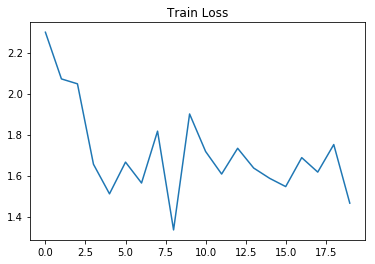

In [112]:
from matplotlib import pyplot as plt
plt.plot(train_loss_list)
plt.title('Train Loss')

Text(0.5, 1.0, 'Test Loss')

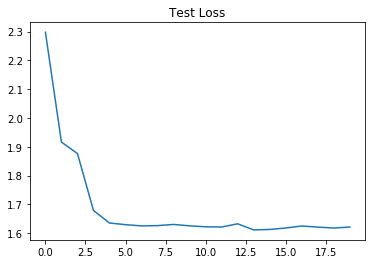

In [113]:
plt.plot(test_loss_list)
plt.title('Test Loss')

In [197]:
# Save model
model_name = 'Lenet_'+str(epoch)+'.tar'
torch.save({
    'epoch':epoch,
    'state_dict':model.state_dict(),
}, model_name)

In [32]:
# Deeper
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, kernel_size = (5, 5), stride = 1, padding = 0)
        self.conv2 = nn.Conv2d(12, 32, kernel_size = (5, 5), stride = 1, padding = 0)
        self.fc1 = nn.Linear(32*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        # Flatten
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

In [33]:
# Wider
class Net_Wider(nn.Module):
    def __init__(self):
        super(Net_Wider, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size = (5, 5), stride = 1, padding = 0)
        self.conv1_1 = nn.Conv2d(6, 6, kernel_size = (3, 3), stride = 1, padding = 1)
        self.conv1_2 = nn.Conv2d(6, 6, kernel_size = (3, 3), stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size = (5, 5), stride = 1, padding = 0)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        # Added layer
        out = F.relu(self.conv1_1(out))
        out = F.relu(self.conv1_2(out))
        
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        # Flatten
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        return out

In [241]:
model_1 = Net_Deeper()
model_1.to(device)

Net_Deeper(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [248]:
model_2 = Net_Deeper()
model_2.to(device)

Net_Deeper(
  (conv1): Conv2d(1, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [250]:
for i in range(1, epoch+1):
    train(i, model_2)
    test(i, model_2)

Train epoch: 1 [0/60000 (0)%]	 Loss: 2.301582
Train epoch: 1 [128/60000 (0)%]	 Loss: 2.303917
Train epoch: 1 [256/60000 (0)%]	 Loss: 2.295136
Train epoch: 1 [384/60000 (1)%]	 Loss: 2.300585
Train epoch: 1 [512/60000 (1)%]	 Loss: 2.304320
Train epoch: 1 [640/60000 (1)%]	 Loss: 2.303223
Train epoch: 1 [768/60000 (1)%]	 Loss: 2.298962
Train epoch: 1 [896/60000 (1)%]	 Loss: 2.294562
Train epoch: 1 [1024/60000 (2)%]	 Loss: 2.294526
Train epoch: 1 [1152/60000 (2)%]	 Loss: 2.294845
Train epoch: 1 [1280/60000 (2)%]	 Loss: 2.296515
Train epoch: 1 [1408/60000 (2)%]	 Loss: 2.298023
Train epoch: 1 [1536/60000 (3)%]	 Loss: 2.289447
Train epoch: 1 [1664/60000 (3)%]	 Loss: 2.289902
Train epoch: 1 [1792/60000 (3)%]	 Loss: 2.291173
Train epoch: 1 [1920/60000 (3)%]	 Loss: 2.289330
Train epoch: 1 [2048/60000 (3)%]	 Loss: 2.295168
Train epoch: 1 [2176/60000 (4)%]	 Loss: 2.290999
Train epoch: 1 [2304/60000 (4)%]	 Loss: 2.286812
Train epoch: 1 [2432/60000 (4)%]	 Loss: 2.289554
Train epoch: 1 [2560/60000 (4)

Train epoch: 1 [21888/60000 (36)%]	 Loss: 0.696403
Train epoch: 1 [22016/60000 (37)%]	 Loss: 0.694824
Train epoch: 1 [22144/60000 (37)%]	 Loss: 0.582449
Train epoch: 1 [22272/60000 (37)%]	 Loss: 0.769056
Train epoch: 1 [22400/60000 (37)%]	 Loss: 0.661190
Train epoch: 1 [22528/60000 (38)%]	 Loss: 0.706378
Train epoch: 1 [22656/60000 (38)%]	 Loss: 0.609574
Train epoch: 1 [22784/60000 (38)%]	 Loss: 0.750603
Train epoch: 1 [22912/60000 (38)%]	 Loss: 0.918707
Train epoch: 1 [23040/60000 (38)%]	 Loss: 0.579025
Train epoch: 1 [23168/60000 (39)%]	 Loss: 0.753469
Train epoch: 1 [23296/60000 (39)%]	 Loss: 0.783013
Train epoch: 1 [23424/60000 (39)%]	 Loss: 0.604426
Train epoch: 1 [23552/60000 (39)%]	 Loss: 0.427460
Train epoch: 1 [23680/60000 (39)%]	 Loss: 0.611173
Train epoch: 1 [23808/60000 (40)%]	 Loss: 0.551066
Train epoch: 1 [23936/60000 (40)%]	 Loss: 0.507628
Train epoch: 1 [24064/60000 (40)%]	 Loss: 0.498030
Train epoch: 1 [24192/60000 (40)%]	 Loss: 0.422746
Train epoch: 1 [24320/60000 (41

Train epoch: 1 [43520/60000 (72)%]	 Loss: 0.204909
Train epoch: 1 [43648/60000 (73)%]	 Loss: 0.127452
Train epoch: 1 [43776/60000 (73)%]	 Loss: 0.066304
Train epoch: 1 [43904/60000 (73)%]	 Loss: 0.096878
Train epoch: 1 [44032/60000 (73)%]	 Loss: 0.131152
Train epoch: 1 [44160/60000 (74)%]	 Loss: 0.193088
Train epoch: 1 [44288/60000 (74)%]	 Loss: 0.152898
Train epoch: 1 [44416/60000 (74)%]	 Loss: 0.299288
Train epoch: 1 [44544/60000 (74)%]	 Loss: 0.096480
Train epoch: 1 [44672/60000 (74)%]	 Loss: 0.068856
Train epoch: 1 [44800/60000 (75)%]	 Loss: 0.110141
Train epoch: 1 [44928/60000 (75)%]	 Loss: 0.102661
Train epoch: 1 [45056/60000 (75)%]	 Loss: 0.086882
Train epoch: 1 [45184/60000 (75)%]	 Loss: 0.180949
Train epoch: 1 [45312/60000 (75)%]	 Loss: 0.130436
Train epoch: 1 [45440/60000 (76)%]	 Loss: 0.141797
Train epoch: 1 [45568/60000 (76)%]	 Loss: 0.146037
Train epoch: 1 [45696/60000 (76)%]	 Loss: 0.177903
Train epoch: 1 [45824/60000 (76)%]	 Loss: 0.095133
Train epoch: 1 [45952/60000 (77

Train epoch: 2 [4352/60000 (7)%]	 Loss: 0.190327
Train epoch: 2 [4480/60000 (7)%]	 Loss: 0.052924
Train epoch: 2 [4608/60000 (8)%]	 Loss: 0.045912
Train epoch: 2 [4736/60000 (8)%]	 Loss: 0.166374
Train epoch: 2 [4864/60000 (8)%]	 Loss: 0.098308
Train epoch: 2 [4992/60000 (8)%]	 Loss: 0.036847
Train epoch: 2 [5120/60000 (9)%]	 Loss: 0.040239
Train epoch: 2 [5248/60000 (9)%]	 Loss: 0.087319
Train epoch: 2 [5376/60000 (9)%]	 Loss: 0.087839
Train epoch: 2 [5504/60000 (9)%]	 Loss: 0.094933
Train epoch: 2 [5632/60000 (9)%]	 Loss: 0.123131
Train epoch: 2 [5760/60000 (10)%]	 Loss: 0.110402
Train epoch: 2 [5888/60000 (10)%]	 Loss: 0.173088
Train epoch: 2 [6016/60000 (10)%]	 Loss: 0.058989
Train epoch: 2 [6144/60000 (10)%]	 Loss: 0.076213
Train epoch: 2 [6272/60000 (10)%]	 Loss: 0.108412
Train epoch: 2 [6400/60000 (11)%]	 Loss: 0.057008
Train epoch: 2 [6528/60000 (11)%]	 Loss: 0.065671
Train epoch: 2 [6656/60000 (11)%]	 Loss: 0.041373
Train epoch: 2 [6784/60000 (11)%]	 Loss: 0.056119
Train epoch

Train epoch: 2 [25216/60000 (42)%]	 Loss: 0.119685
Train epoch: 2 [25344/60000 (42)%]	 Loss: 0.116024
Train epoch: 2 [25472/60000 (42)%]	 Loss: 0.035705
Train epoch: 2 [25600/60000 (43)%]	 Loss: 0.106867
Train epoch: 2 [25728/60000 (43)%]	 Loss: 0.057719
Train epoch: 2 [25856/60000 (43)%]	 Loss: 0.051278
Train epoch: 2 [25984/60000 (43)%]	 Loss: 0.102688
Train epoch: 2 [26112/60000 (43)%]	 Loss: 0.049020
Train epoch: 2 [26240/60000 (44)%]	 Loss: 0.085602
Train epoch: 2 [26368/60000 (44)%]	 Loss: 0.040235
Train epoch: 2 [26496/60000 (44)%]	 Loss: 0.107574
Train epoch: 2 [26624/60000 (44)%]	 Loss: 0.030845
Train epoch: 2 [26752/60000 (45)%]	 Loss: 0.157083
Train epoch: 2 [26880/60000 (45)%]	 Loss: 0.021577
Train epoch: 2 [27008/60000 (45)%]	 Loss: 0.126778
Train epoch: 2 [27136/60000 (45)%]	 Loss: 0.226754
Train epoch: 2 [27264/60000 (45)%]	 Loss: 0.098998
Train epoch: 2 [27392/60000 (46)%]	 Loss: 0.098552
Train epoch: 2 [27520/60000 (46)%]	 Loss: 0.063545
Train epoch: 2 [27648/60000 (46

Train epoch: 2 [48256/60000 (80)%]	 Loss: 0.054820
Train epoch: 2 [48384/60000 (81)%]	 Loss: 0.105101
Train epoch: 2 [48512/60000 (81)%]	 Loss: 0.061580
Train epoch: 2 [48640/60000 (81)%]	 Loss: 0.162949
Train epoch: 2 [48768/60000 (81)%]	 Loss: 0.036405
Train epoch: 2 [48896/60000 (81)%]	 Loss: 0.011270
Train epoch: 2 [49024/60000 (82)%]	 Loss: 0.049570
Train epoch: 2 [49152/60000 (82)%]	 Loss: 0.041600
Train epoch: 2 [49280/60000 (82)%]	 Loss: 0.063279
Train epoch: 2 [49408/60000 (82)%]	 Loss: 0.078126
Train epoch: 2 [49536/60000 (83)%]	 Loss: 0.048494
Train epoch: 2 [49664/60000 (83)%]	 Loss: 0.161109
Train epoch: 2 [49792/60000 (83)%]	 Loss: 0.085859
Train epoch: 2 [49920/60000 (83)%]	 Loss: 0.035340
Train epoch: 2 [50048/60000 (83)%]	 Loss: 0.055921
Train epoch: 2 [50176/60000 (84)%]	 Loss: 0.112742
Train epoch: 2 [50304/60000 (84)%]	 Loss: 0.071420
Train epoch: 2 [50432/60000 (84)%]	 Loss: 0.059487
Train epoch: 2 [50560/60000 (84)%]	 Loss: 0.102497
Train epoch: 2 [50688/60000 (84

Train epoch: 3 [11520/60000 (19)%]	 Loss: 0.118242
Train epoch: 3 [11648/60000 (19)%]	 Loss: 0.033445
Train epoch: 3 [11776/60000 (20)%]	 Loss: 0.038288
Train epoch: 3 [11904/60000 (20)%]	 Loss: 0.034884
Train epoch: 3 [12032/60000 (20)%]	 Loss: 0.058675
Train epoch: 3 [12160/60000 (20)%]	 Loss: 0.063284
Train epoch: 3 [12288/60000 (20)%]	 Loss: 0.043109
Train epoch: 3 [12416/60000 (21)%]	 Loss: 0.051891
Train epoch: 3 [12544/60000 (21)%]	 Loss: 0.058920
Train epoch: 3 [12672/60000 (21)%]	 Loss: 0.046465
Train epoch: 3 [12800/60000 (21)%]	 Loss: 0.148547
Train epoch: 3 [12928/60000 (22)%]	 Loss: 0.055307
Train epoch: 3 [13056/60000 (22)%]	 Loss: 0.011231
Train epoch: 3 [13184/60000 (22)%]	 Loss: 0.046169
Train epoch: 3 [13312/60000 (22)%]	 Loss: 0.080217
Train epoch: 3 [13440/60000 (22)%]	 Loss: 0.051970
Train epoch: 3 [13568/60000 (23)%]	 Loss: 0.014735
Train epoch: 3 [13696/60000 (23)%]	 Loss: 0.060818
Train epoch: 3 [13824/60000 (23)%]	 Loss: 0.224983
Train epoch: 3 [13952/60000 (23

Train epoch: 3 [33024/60000 (55)%]	 Loss: 0.060550
Train epoch: 3 [33152/60000 (55)%]	 Loss: 0.031063
Train epoch: 3 [33280/60000 (55)%]	 Loss: 0.080999
Train epoch: 3 [33408/60000 (56)%]	 Loss: 0.007859
Train epoch: 3 [33536/60000 (56)%]	 Loss: 0.054398
Train epoch: 3 [33664/60000 (56)%]	 Loss: 0.092609
Train epoch: 3 [33792/60000 (56)%]	 Loss: 0.025399
Train epoch: 3 [33920/60000 (57)%]	 Loss: 0.072922
Train epoch: 3 [34048/60000 (57)%]	 Loss: 0.020304
Train epoch: 3 [34176/60000 (57)%]	 Loss: 0.037608
Train epoch: 3 [34304/60000 (57)%]	 Loss: 0.083732
Train epoch: 3 [34432/60000 (57)%]	 Loss: 0.013272
Train epoch: 3 [34560/60000 (58)%]	 Loss: 0.034135
Train epoch: 3 [34688/60000 (58)%]	 Loss: 0.033476
Train epoch: 3 [34816/60000 (58)%]	 Loss: 0.066704
Train epoch: 3 [34944/60000 (58)%]	 Loss: 0.073308
Train epoch: 3 [35072/60000 (58)%]	 Loss: 0.045677
Train epoch: 3 [35200/60000 (59)%]	 Loss: 0.039262
Train epoch: 3 [35328/60000 (59)%]	 Loss: 0.009134
Train epoch: 3 [35456/60000 (59

Train epoch: 3 [54784/60000 (91)%]	 Loss: 0.014062
Train epoch: 3 [54912/60000 (91)%]	 Loss: 0.021975
Train epoch: 3 [55040/60000 (92)%]	 Loss: 0.039149
Train epoch: 3 [55168/60000 (92)%]	 Loss: 0.065966
Train epoch: 3 [55296/60000 (92)%]	 Loss: 0.020886
Train epoch: 3 [55424/60000 (92)%]	 Loss: 0.038513
Train epoch: 3 [55552/60000 (93)%]	 Loss: 0.030996
Train epoch: 3 [55680/60000 (93)%]	 Loss: 0.040973
Train epoch: 3 [55808/60000 (93)%]	 Loss: 0.063490
Train epoch: 3 [55936/60000 (93)%]	 Loss: 0.106013
Train epoch: 3 [56064/60000 (93)%]	 Loss: 0.025716
Train epoch: 3 [56192/60000 (94)%]	 Loss: 0.044327
Train epoch: 3 [56320/60000 (94)%]	 Loss: 0.027450
Train epoch: 3 [56448/60000 (94)%]	 Loss: 0.079579
Train epoch: 3 [56576/60000 (94)%]	 Loss: 0.094572
Train epoch: 3 [56704/60000 (94)%]	 Loss: 0.025105
Train epoch: 3 [56832/60000 (95)%]	 Loss: 0.024209
Train epoch: 3 [56960/60000 (95)%]	 Loss: 0.024683
Train epoch: 3 [57088/60000 (95)%]	 Loss: 0.038506
Train epoch: 3 [57216/60000 (95

Train epoch: 4 [16000/60000 (27)%]	 Loss: 0.047550
Train epoch: 4 [16128/60000 (27)%]	 Loss: 0.035753
Train epoch: 4 [16256/60000 (27)%]	 Loss: 0.052131
Train epoch: 4 [16384/60000 (27)%]	 Loss: 0.021319
Train epoch: 4 [16512/60000 (28)%]	 Loss: 0.065190
Train epoch: 4 [16640/60000 (28)%]	 Loss: 0.029812
Train epoch: 4 [16768/60000 (28)%]	 Loss: 0.015115
Train epoch: 4 [16896/60000 (28)%]	 Loss: 0.040192
Train epoch: 4 [17024/60000 (28)%]	 Loss: 0.043940
Train epoch: 4 [17152/60000 (29)%]	 Loss: 0.057766
Train epoch: 4 [17280/60000 (29)%]	 Loss: 0.005648
Train epoch: 4 [17408/60000 (29)%]	 Loss: 0.018048
Train epoch: 4 [17536/60000 (29)%]	 Loss: 0.009017
Train epoch: 4 [17664/60000 (29)%]	 Loss: 0.021185
Train epoch: 4 [17792/60000 (30)%]	 Loss: 0.016827
Train epoch: 4 [17920/60000 (30)%]	 Loss: 0.019363
Train epoch: 4 [18048/60000 (30)%]	 Loss: 0.047816
Train epoch: 4 [18176/60000 (30)%]	 Loss: 0.026071
Train epoch: 4 [18304/60000 (30)%]	 Loss: 0.021795
Train epoch: 4 [18432/60000 (31

Train epoch: 4 [36992/60000 (62)%]	 Loss: 0.017623
Train epoch: 4 [37120/60000 (62)%]	 Loss: 0.028181
Train epoch: 4 [37248/60000 (62)%]	 Loss: 0.068548
Train epoch: 4 [37376/60000 (62)%]	 Loss: 0.022067
Train epoch: 4 [37504/60000 (62)%]	 Loss: 0.035007
Train epoch: 4 [37632/60000 (63)%]	 Loss: 0.048130
Train epoch: 4 [37760/60000 (63)%]	 Loss: 0.034068
Train epoch: 4 [37888/60000 (63)%]	 Loss: 0.013092
Train epoch: 4 [38016/60000 (63)%]	 Loss: 0.020316
Train epoch: 4 [38144/60000 (64)%]	 Loss: 0.043569
Train epoch: 4 [38272/60000 (64)%]	 Loss: 0.020211
Train epoch: 4 [38400/60000 (64)%]	 Loss: 0.020338
Train epoch: 4 [38528/60000 (64)%]	 Loss: 0.080581
Train epoch: 4 [38656/60000 (64)%]	 Loss: 0.014593
Train epoch: 4 [38784/60000 (65)%]	 Loss: 0.057355
Train epoch: 4 [38912/60000 (65)%]	 Loss: 0.121930
Train epoch: 4 [39040/60000 (65)%]	 Loss: 0.017420
Train epoch: 4 [39168/60000 (65)%]	 Loss: 0.031368
Train epoch: 4 [39296/60000 (65)%]	 Loss: 0.060915
Train epoch: 4 [39424/60000 (66

Train epoch: 4 [58752/60000 (98)%]	 Loss: 0.030027
Train epoch: 4 [58880/60000 (98)%]	 Loss: 0.012178
Train epoch: 4 [59008/60000 (98)%]	 Loss: 0.038669
Train epoch: 4 [59136/60000 (99)%]	 Loss: 0.023142
Train epoch: 4 [59264/60000 (99)%]	 Loss: 0.024866
Train epoch: 4 [59392/60000 (99)%]	 Loss: 0.027690
Train epoch: 4 [59520/60000 (99)%]	 Loss: 0.009667
Train epoch: 4 [59648/60000 (99)%]	 Loss: 0.005727
Train epoch: 4 [59776/60000 (100)%]	 Loss: 0.030006
Train epoch: 4 [44928/60000 (100)%]	 Loss: 0.056766

Test set: Average loss: 0.0322, Accurarcy: 9894/10000 (98.94%)

Train epoch: 5 [0/60000 (0)%]	 Loss: 0.019103
Train epoch: 5 [128/60000 (0)%]	 Loss: 0.022568
Train epoch: 5 [256/60000 (0)%]	 Loss: 0.044825
Train epoch: 5 [384/60000 (1)%]	 Loss: 0.064807
Train epoch: 5 [512/60000 (1)%]	 Loss: 0.035017
Train epoch: 5 [640/60000 (1)%]	 Loss: 0.021867
Train epoch: 5 [768/60000 (1)%]	 Loss: 0.010971
Train epoch: 5 [896/60000 (1)%]	 Loss: 0.018517
Train epoch: 5 [1024/60000 (2)%]	 Loss: 0

Train epoch: 5 [20480/60000 (34)%]	 Loss: 0.068614
Train epoch: 5 [20608/60000 (34)%]	 Loss: 0.074967
Train epoch: 5 [20736/60000 (35)%]	 Loss: 0.043987
Train epoch: 5 [20864/60000 (35)%]	 Loss: 0.020587
Train epoch: 5 [20992/60000 (35)%]	 Loss: 0.021903
Train epoch: 5 [21120/60000 (35)%]	 Loss: 0.016527
Train epoch: 5 [21248/60000 (35)%]	 Loss: 0.026113
Train epoch: 5 [21376/60000 (36)%]	 Loss: 0.056284
Train epoch: 5 [21504/60000 (36)%]	 Loss: 0.112897
Train epoch: 5 [21632/60000 (36)%]	 Loss: 0.026045
Train epoch: 5 [21760/60000 (36)%]	 Loss: 0.005884
Train epoch: 5 [21888/60000 (36)%]	 Loss: 0.005612
Train epoch: 5 [22016/60000 (37)%]	 Loss: 0.003582
Train epoch: 5 [22144/60000 (37)%]	 Loss: 0.055052
Train epoch: 5 [22272/60000 (37)%]	 Loss: 0.010332
Train epoch: 5 [22400/60000 (37)%]	 Loss: 0.016000
Train epoch: 5 [22528/60000 (38)%]	 Loss: 0.019554
Train epoch: 5 [22656/60000 (38)%]	 Loss: 0.019116
Train epoch: 5 [22784/60000 (38)%]	 Loss: 0.034473
Train epoch: 5 [22912/60000 (38

Train epoch: 5 [42240/60000 (70)%]	 Loss: 0.031244
Train epoch: 5 [42368/60000 (71)%]	 Loss: 0.029017
Train epoch: 5 [42496/60000 (71)%]	 Loss: 0.037143
Train epoch: 5 [42624/60000 (71)%]	 Loss: 0.060361
Train epoch: 5 [42752/60000 (71)%]	 Loss: 0.043262
Train epoch: 5 [42880/60000 (71)%]	 Loss: 0.021806
Train epoch: 5 [43008/60000 (72)%]	 Loss: 0.004988
Train epoch: 5 [43136/60000 (72)%]	 Loss: 0.021933
Train epoch: 5 [43264/60000 (72)%]	 Loss: 0.036454
Train epoch: 5 [43392/60000 (72)%]	 Loss: 0.046225
Train epoch: 5 [43520/60000 (72)%]	 Loss: 0.007335
Train epoch: 5 [43648/60000 (73)%]	 Loss: 0.039879
Train epoch: 5 [43776/60000 (73)%]	 Loss: 0.019252
Train epoch: 5 [43904/60000 (73)%]	 Loss: 0.008574
Train epoch: 5 [44032/60000 (73)%]	 Loss: 0.016184
Train epoch: 5 [44160/60000 (74)%]	 Loss: 0.044366
Train epoch: 5 [44288/60000 (74)%]	 Loss: 0.036852
Train epoch: 5 [44416/60000 (74)%]	 Loss: 0.020805
Train epoch: 5 [44544/60000 (74)%]	 Loss: 0.012287
Train epoch: 5 [44672/60000 (74

Train epoch: 6 [3200/60000 (5)%]	 Loss: 0.009144
Train epoch: 6 [3328/60000 (6)%]	 Loss: 0.023195
Train epoch: 6 [3456/60000 (6)%]	 Loss: 0.050201
Train epoch: 6 [3584/60000 (6)%]	 Loss: 0.056328
Train epoch: 6 [3712/60000 (6)%]	 Loss: 0.002934
Train epoch: 6 [3840/60000 (6)%]	 Loss: 0.006849
Train epoch: 6 [3968/60000 (7)%]	 Loss: 0.045043
Train epoch: 6 [4096/60000 (7)%]	 Loss: 0.011961
Train epoch: 6 [4224/60000 (7)%]	 Loss: 0.037002
Train epoch: 6 [4352/60000 (7)%]	 Loss: 0.007968
Train epoch: 6 [4480/60000 (7)%]	 Loss: 0.021074
Train epoch: 6 [4608/60000 (8)%]	 Loss: 0.021923
Train epoch: 6 [4736/60000 (8)%]	 Loss: 0.019492
Train epoch: 6 [4864/60000 (8)%]	 Loss: 0.042352
Train epoch: 6 [4992/60000 (8)%]	 Loss: 0.028225
Train epoch: 6 [5120/60000 (9)%]	 Loss: 0.009440
Train epoch: 6 [5248/60000 (9)%]	 Loss: 0.029327
Train epoch: 6 [5376/60000 (9)%]	 Loss: 0.004188
Train epoch: 6 [5504/60000 (9)%]	 Loss: 0.002724
Train epoch: 6 [5632/60000 (9)%]	 Loss: 0.006342
Train epoch: 6 [5760

Train epoch: 6 [24320/60000 (41)%]	 Loss: 0.024603
Train epoch: 6 [24448/60000 (41)%]	 Loss: 0.016540
Train epoch: 6 [24576/60000 (41)%]	 Loss: 0.029551
Train epoch: 6 [24704/60000 (41)%]	 Loss: 0.029131
Train epoch: 6 [24832/60000 (41)%]	 Loss: 0.067904
Train epoch: 6 [24960/60000 (42)%]	 Loss: 0.020743
Train epoch: 6 [25088/60000 (42)%]	 Loss: 0.036329
Train epoch: 6 [25216/60000 (42)%]	 Loss: 0.031469
Train epoch: 6 [25344/60000 (42)%]	 Loss: 0.019374
Train epoch: 6 [25472/60000 (42)%]	 Loss: 0.007314
Train epoch: 6 [25600/60000 (43)%]	 Loss: 0.022813
Train epoch: 6 [25728/60000 (43)%]	 Loss: 0.024253
Train epoch: 6 [25856/60000 (43)%]	 Loss: 0.018763
Train epoch: 6 [25984/60000 (43)%]	 Loss: 0.053031
Train epoch: 6 [26112/60000 (43)%]	 Loss: 0.004781
Train epoch: 6 [26240/60000 (44)%]	 Loss: 0.014747
Train epoch: 6 [26368/60000 (44)%]	 Loss: 0.017873
Train epoch: 6 [26496/60000 (44)%]	 Loss: 0.034306
Train epoch: 6 [26624/60000 (44)%]	 Loss: 0.032382
Train epoch: 6 [26752/60000 (45

Train epoch: 6 [45056/60000 (75)%]	 Loss: 0.008616
Train epoch: 6 [45184/60000 (75)%]	 Loss: 0.042097
Train epoch: 6 [45312/60000 (75)%]	 Loss: 0.015657
Train epoch: 6 [45440/60000 (76)%]	 Loss: 0.030582
Train epoch: 6 [45568/60000 (76)%]	 Loss: 0.014456
Train epoch: 6 [45696/60000 (76)%]	 Loss: 0.016665
Train epoch: 6 [45824/60000 (76)%]	 Loss: 0.013223
Train epoch: 6 [45952/60000 (77)%]	 Loss: 0.004555
Train epoch: 6 [46080/60000 (77)%]	 Loss: 0.014280
Train epoch: 6 [46208/60000 (77)%]	 Loss: 0.009644
Train epoch: 6 [46336/60000 (77)%]	 Loss: 0.082609
Train epoch: 6 [46464/60000 (77)%]	 Loss: 0.023950
Train epoch: 6 [46592/60000 (78)%]	 Loss: 0.005172
Train epoch: 6 [46720/60000 (78)%]	 Loss: 0.040167
Train epoch: 6 [46848/60000 (78)%]	 Loss: 0.010014
Train epoch: 6 [46976/60000 (78)%]	 Loss: 0.005671
Train epoch: 6 [47104/60000 (78)%]	 Loss: 0.032905
Train epoch: 6 [47232/60000 (79)%]	 Loss: 0.002757
Train epoch: 6 [47360/60000 (79)%]	 Loss: 0.002191
Train epoch: 6 [47488/60000 (79

Train epoch: 7 [7424/60000 (12)%]	 Loss: 0.005873
Train epoch: 7 [7552/60000 (13)%]	 Loss: 0.003462
Train epoch: 7 [7680/60000 (13)%]	 Loss: 0.026367
Train epoch: 7 [7808/60000 (13)%]	 Loss: 0.002698
Train epoch: 7 [7936/60000 (13)%]	 Loss: 0.042346
Train epoch: 7 [8064/60000 (13)%]	 Loss: 0.027380
Train epoch: 7 [8192/60000 (14)%]	 Loss: 0.004135
Train epoch: 7 [8320/60000 (14)%]	 Loss: 0.051169
Train epoch: 7 [8448/60000 (14)%]	 Loss: 0.009219
Train epoch: 7 [8576/60000 (14)%]	 Loss: 0.012193
Train epoch: 7 [8704/60000 (14)%]	 Loss: 0.014455
Train epoch: 7 [8832/60000 (15)%]	 Loss: 0.002190
Train epoch: 7 [8960/60000 (15)%]	 Loss: 0.001649
Train epoch: 7 [9088/60000 (15)%]	 Loss: 0.023813
Train epoch: 7 [9216/60000 (15)%]	 Loss: 0.078097
Train epoch: 7 [9344/60000 (16)%]	 Loss: 0.060412
Train epoch: 7 [9472/60000 (16)%]	 Loss: 0.004153
Train epoch: 7 [9600/60000 (16)%]	 Loss: 0.020731
Train epoch: 7 [9728/60000 (16)%]	 Loss: 0.023290
Train epoch: 7 [9856/60000 (16)%]	 Loss: 0.007589


Train epoch: 7 [28160/60000 (47)%]	 Loss: 0.019558
Train epoch: 7 [28288/60000 (47)%]	 Loss: 0.067902
Train epoch: 7 [28416/60000 (47)%]	 Loss: 0.018992
Train epoch: 7 [28544/60000 (48)%]	 Loss: 0.030917
Train epoch: 7 [28672/60000 (48)%]	 Loss: 0.023833
Train epoch: 7 [28800/60000 (48)%]	 Loss: 0.009955
Train epoch: 7 [28928/60000 (48)%]	 Loss: 0.075150
Train epoch: 7 [29056/60000 (48)%]	 Loss: 0.002845
Train epoch: 7 [29184/60000 (49)%]	 Loss: 0.034323
Train epoch: 7 [29312/60000 (49)%]	 Loss: 0.007195
Train epoch: 7 [29440/60000 (49)%]	 Loss: 0.034287
Train epoch: 7 [29568/60000 (49)%]	 Loss: 0.028514
Train epoch: 7 [29696/60000 (49)%]	 Loss: 0.023249
Train epoch: 7 [29824/60000 (50)%]	 Loss: 0.007866
Train epoch: 7 [29952/60000 (50)%]	 Loss: 0.015272
Train epoch: 7 [30080/60000 (50)%]	 Loss: 0.042884
Train epoch: 7 [30208/60000 (50)%]	 Loss: 0.017031
Train epoch: 7 [30336/60000 (51)%]	 Loss: 0.067915
Train epoch: 7 [30464/60000 (51)%]	 Loss: 0.027300
Train epoch: 7 [30592/60000 (51

Train epoch: 7 [49024/60000 (82)%]	 Loss: 0.061691
Train epoch: 7 [49152/60000 (82)%]	 Loss: 0.031182
Train epoch: 7 [49280/60000 (82)%]	 Loss: 0.006008
Train epoch: 7 [49408/60000 (82)%]	 Loss: 0.020145
Train epoch: 7 [49536/60000 (83)%]	 Loss: 0.024214
Train epoch: 7 [49664/60000 (83)%]	 Loss: 0.018346
Train epoch: 7 [49792/60000 (83)%]	 Loss: 0.019439
Train epoch: 7 [49920/60000 (83)%]	 Loss: 0.021466
Train epoch: 7 [50048/60000 (83)%]	 Loss: 0.004571
Train epoch: 7 [50176/60000 (84)%]	 Loss: 0.020004
Train epoch: 7 [50304/60000 (84)%]	 Loss: 0.026522
Train epoch: 7 [50432/60000 (84)%]	 Loss: 0.013087
Train epoch: 7 [50560/60000 (84)%]	 Loss: 0.015824
Train epoch: 7 [50688/60000 (84)%]	 Loss: 0.054764
Train epoch: 7 [50816/60000 (85)%]	 Loss: 0.009132
Train epoch: 7 [50944/60000 (85)%]	 Loss: 0.002585
Train epoch: 7 [51072/60000 (85)%]	 Loss: 0.083882
Train epoch: 7 [51200/60000 (85)%]	 Loss: 0.002876
Train epoch: 7 [51328/60000 (86)%]	 Loss: 0.004408
Train epoch: 7 [51456/60000 (86

Train epoch: 8 [11392/60000 (19)%]	 Loss: 0.003660
Train epoch: 8 [11520/60000 (19)%]	 Loss: 0.001086
Train epoch: 8 [11648/60000 (19)%]	 Loss: 0.006258
Train epoch: 8 [11776/60000 (20)%]	 Loss: 0.004480
Train epoch: 8 [11904/60000 (20)%]	 Loss: 0.025637
Train epoch: 8 [12032/60000 (20)%]	 Loss: 0.004327
Train epoch: 8 [12160/60000 (20)%]	 Loss: 0.001797
Train epoch: 8 [12288/60000 (20)%]	 Loss: 0.015430
Train epoch: 8 [12416/60000 (21)%]	 Loss: 0.008389
Train epoch: 8 [12544/60000 (21)%]	 Loss: 0.049258
Train epoch: 8 [12672/60000 (21)%]	 Loss: 0.054259
Train epoch: 8 [12800/60000 (21)%]	 Loss: 0.001763
Train epoch: 8 [12928/60000 (22)%]	 Loss: 0.002570
Train epoch: 8 [13056/60000 (22)%]	 Loss: 0.013350
Train epoch: 8 [13184/60000 (22)%]	 Loss: 0.058594
Train epoch: 8 [13312/60000 (22)%]	 Loss: 0.041744
Train epoch: 8 [13440/60000 (22)%]	 Loss: 0.025178
Train epoch: 8 [13568/60000 (23)%]	 Loss: 0.019250
Train epoch: 8 [13696/60000 (23)%]	 Loss: 0.022786
Train epoch: 8 [13824/60000 (23

Train epoch: 8 [32384/60000 (54)%]	 Loss: 0.023534
Train epoch: 8 [32512/60000 (54)%]	 Loss: 0.017738
Train epoch: 8 [32640/60000 (54)%]	 Loss: 0.002261
Train epoch: 8 [32768/60000 (55)%]	 Loss: 0.001445
Train epoch: 8 [32896/60000 (55)%]	 Loss: 0.025128
Train epoch: 8 [33024/60000 (55)%]	 Loss: 0.009898
Train epoch: 8 [33152/60000 (55)%]	 Loss: 0.004961
Train epoch: 8 [33280/60000 (55)%]	 Loss: 0.001475
Train epoch: 8 [33408/60000 (56)%]	 Loss: 0.033275
Train epoch: 8 [33536/60000 (56)%]	 Loss: 0.039682
Train epoch: 8 [33664/60000 (56)%]	 Loss: 0.005032
Train epoch: 8 [33792/60000 (56)%]	 Loss: 0.008922
Train epoch: 8 [33920/60000 (57)%]	 Loss: 0.030983
Train epoch: 8 [34048/60000 (57)%]	 Loss: 0.015537
Train epoch: 8 [34176/60000 (57)%]	 Loss: 0.006222
Train epoch: 8 [34304/60000 (57)%]	 Loss: 0.026001
Train epoch: 8 [34432/60000 (57)%]	 Loss: 0.043078
Train epoch: 8 [34560/60000 (58)%]	 Loss: 0.002543
Train epoch: 8 [34688/60000 (58)%]	 Loss: 0.001789
Train epoch: 8 [34816/60000 (58

Train epoch: 8 [53504/60000 (89)%]	 Loss: 0.014193
Train epoch: 8 [53632/60000 (89)%]	 Loss: 0.016834
Train epoch: 8 [53760/60000 (90)%]	 Loss: 0.006394
Train epoch: 8 [53888/60000 (90)%]	 Loss: 0.003143
Train epoch: 8 [54016/60000 (90)%]	 Loss: 0.003752
Train epoch: 8 [54144/60000 (90)%]	 Loss: 0.010914
Train epoch: 8 [54272/60000 (90)%]	 Loss: 0.055142
Train epoch: 8 [54400/60000 (91)%]	 Loss: 0.001769
Train epoch: 8 [54528/60000 (91)%]	 Loss: 0.051491
Train epoch: 8 [54656/60000 (91)%]	 Loss: 0.021061
Train epoch: 8 [54784/60000 (91)%]	 Loss: 0.002580
Train epoch: 8 [54912/60000 (91)%]	 Loss: 0.008571
Train epoch: 8 [55040/60000 (92)%]	 Loss: 0.002698
Train epoch: 8 [55168/60000 (92)%]	 Loss: 0.088049
Train epoch: 8 [55296/60000 (92)%]	 Loss: 0.008499
Train epoch: 8 [55424/60000 (92)%]	 Loss: 0.012919
Train epoch: 8 [55552/60000 (93)%]	 Loss: 0.014949
Train epoch: 8 [55680/60000 (93)%]	 Loss: 0.001137
Train epoch: 8 [55808/60000 (93)%]	 Loss: 0.005539
Train epoch: 8 [55936/60000 (93

Train epoch: 9 [15872/60000 (26)%]	 Loss: 0.001152
Train epoch: 9 [16000/60000 (27)%]	 Loss: 0.003370
Train epoch: 9 [16128/60000 (27)%]	 Loss: 0.003083
Train epoch: 9 [16256/60000 (27)%]	 Loss: 0.014875
Train epoch: 9 [16384/60000 (27)%]	 Loss: 0.003559
Train epoch: 9 [16512/60000 (28)%]	 Loss: 0.005743
Train epoch: 9 [16640/60000 (28)%]	 Loss: 0.020642
Train epoch: 9 [16768/60000 (28)%]	 Loss: 0.013883
Train epoch: 9 [16896/60000 (28)%]	 Loss: 0.006438
Train epoch: 9 [17024/60000 (28)%]	 Loss: 0.004952
Train epoch: 9 [17152/60000 (29)%]	 Loss: 0.009608
Train epoch: 9 [17280/60000 (29)%]	 Loss: 0.011451
Train epoch: 9 [17408/60000 (29)%]	 Loss: 0.012528
Train epoch: 9 [17536/60000 (29)%]	 Loss: 0.009967
Train epoch: 9 [17664/60000 (29)%]	 Loss: 0.001247
Train epoch: 9 [17792/60000 (30)%]	 Loss: 0.002786
Train epoch: 9 [17920/60000 (30)%]	 Loss: 0.009645
Train epoch: 9 [18048/60000 (30)%]	 Loss: 0.002077
Train epoch: 9 [18176/60000 (30)%]	 Loss: 0.008922
Train epoch: 9 [18304/60000 (30

Train epoch: 9 [37248/60000 (62)%]	 Loss: 0.001958
Train epoch: 9 [37376/60000 (62)%]	 Loss: 0.021872
Train epoch: 9 [37504/60000 (62)%]	 Loss: 0.028551
Train epoch: 9 [37632/60000 (63)%]	 Loss: 0.001338
Train epoch: 9 [37760/60000 (63)%]	 Loss: 0.005282
Train epoch: 9 [37888/60000 (63)%]	 Loss: 0.008672
Train epoch: 9 [38016/60000 (63)%]	 Loss: 0.036438
Train epoch: 9 [38144/60000 (64)%]	 Loss: 0.011137
Train epoch: 9 [38272/60000 (64)%]	 Loss: 0.003093
Train epoch: 9 [38400/60000 (64)%]	 Loss: 0.003523
Train epoch: 9 [38528/60000 (64)%]	 Loss: 0.050032
Train epoch: 9 [38656/60000 (64)%]	 Loss: 0.047513
Train epoch: 9 [38784/60000 (65)%]	 Loss: 0.121848
Train epoch: 9 [38912/60000 (65)%]	 Loss: 0.002305
Train epoch: 9 [39040/60000 (65)%]	 Loss: 0.028241
Train epoch: 9 [39168/60000 (65)%]	 Loss: 0.031849
Train epoch: 9 [39296/60000 (65)%]	 Loss: 0.005847
Train epoch: 9 [39424/60000 (66)%]	 Loss: 0.014711
Train epoch: 9 [39552/60000 (66)%]	 Loss: 0.011104
Train epoch: 9 [39680/60000 (66

Train epoch: 9 [58368/60000 (97)%]	 Loss: 0.004760
Train epoch: 9 [58496/60000 (97)%]	 Loss: 0.059749
Train epoch: 9 [58624/60000 (98)%]	 Loss: 0.006092
Train epoch: 9 [58752/60000 (98)%]	 Loss: 0.002997
Train epoch: 9 [58880/60000 (98)%]	 Loss: 0.053825
Train epoch: 9 [59008/60000 (98)%]	 Loss: 0.004963
Train epoch: 9 [59136/60000 (99)%]	 Loss: 0.015793
Train epoch: 9 [59264/60000 (99)%]	 Loss: 0.002471
Train epoch: 9 [59392/60000 (99)%]	 Loss: 0.006205
Train epoch: 9 [59520/60000 (99)%]	 Loss: 0.007718
Train epoch: 9 [59648/60000 (99)%]	 Loss: 0.022315
Train epoch: 9 [59776/60000 (100)%]	 Loss: 0.000716
Train epoch: 9 [44928/60000 (100)%]	 Loss: 0.021077

Test set: Average loss: 0.0320, Accurarcy: 9895/10000 (98.95%)

Train epoch: 10 [0/60000 (0)%]	 Loss: 0.017333
Train epoch: 10 [128/60000 (0)%]	 Loss: 0.006697
Train epoch: 10 [256/60000 (0)%]	 Loss: 0.027979
Train epoch: 10 [384/60000 (1)%]	 Loss: 0.002762
Train epoch: 10 [512/60000 (1)%]	 Loss: 0.010983
Train epoch: 10 [640/60000 

Train epoch: 10 [19584/60000 (33)%]	 Loss: 0.004767
Train epoch: 10 [19712/60000 (33)%]	 Loss: 0.004727
Train epoch: 10 [19840/60000 (33)%]	 Loss: 0.007189
Train epoch: 10 [19968/60000 (33)%]	 Loss: 0.047591
Train epoch: 10 [20096/60000 (33)%]	 Loss: 0.019020
Train epoch: 10 [20224/60000 (34)%]	 Loss: 0.002448
Train epoch: 10 [20352/60000 (34)%]	 Loss: 0.012007
Train epoch: 10 [20480/60000 (34)%]	 Loss: 0.001649
Train epoch: 10 [20608/60000 (34)%]	 Loss: 0.001560
Train epoch: 10 [20736/60000 (35)%]	 Loss: 0.003283
Train epoch: 10 [20864/60000 (35)%]	 Loss: 0.005888
Train epoch: 10 [20992/60000 (35)%]	 Loss: 0.000384
Train epoch: 10 [21120/60000 (35)%]	 Loss: 0.006755
Train epoch: 10 [21248/60000 (35)%]	 Loss: 0.004284
Train epoch: 10 [21376/60000 (36)%]	 Loss: 0.008057
Train epoch: 10 [21504/60000 (36)%]	 Loss: 0.011907
Train epoch: 10 [21632/60000 (36)%]	 Loss: 0.006016
Train epoch: 10 [21760/60000 (36)%]	 Loss: 0.011474
Train epoch: 10 [21888/60000 (36)%]	 Loss: 0.018581
Train epoch:

Train epoch: 10 [40576/60000 (68)%]	 Loss: 0.003034
Train epoch: 10 [40704/60000 (68)%]	 Loss: 0.005169
Train epoch: 10 [40832/60000 (68)%]	 Loss: 0.012970
Train epoch: 10 [40960/60000 (68)%]	 Loss: 0.004096
Train epoch: 10 [41088/60000 (68)%]	 Loss: 0.002674
Train epoch: 10 [41216/60000 (69)%]	 Loss: 0.007719
Train epoch: 10 [41344/60000 (69)%]	 Loss: 0.003118
Train epoch: 10 [41472/60000 (69)%]	 Loss: 0.017272
Train epoch: 10 [41600/60000 (69)%]	 Loss: 0.018844
Train epoch: 10 [41728/60000 (70)%]	 Loss: 0.006438
Train epoch: 10 [41856/60000 (70)%]	 Loss: 0.007887
Train epoch: 10 [41984/60000 (70)%]	 Loss: 0.001555
Train epoch: 10 [42112/60000 (70)%]	 Loss: 0.004287
Train epoch: 10 [42240/60000 (70)%]	 Loss: 0.000419
Train epoch: 10 [42368/60000 (71)%]	 Loss: 0.002210
Train epoch: 10 [42496/60000 (71)%]	 Loss: 0.003421
Train epoch: 10 [42624/60000 (71)%]	 Loss: 0.021539
Train epoch: 10 [42752/60000 (71)%]	 Loss: 0.003939
Train epoch: 10 [42880/60000 (71)%]	 Loss: 0.001151
Train epoch:

Train epoch: 11 [3200/60000 (5)%]	 Loss: 0.001429
Train epoch: 11 [3328/60000 (6)%]	 Loss: 0.004716
Train epoch: 11 [3456/60000 (6)%]	 Loss: 0.001484
Train epoch: 11 [3584/60000 (6)%]	 Loss: 0.002219
Train epoch: 11 [3712/60000 (6)%]	 Loss: 0.069168
Train epoch: 11 [3840/60000 (6)%]	 Loss: 0.003590
Train epoch: 11 [3968/60000 (7)%]	 Loss: 0.002364
Train epoch: 11 [4096/60000 (7)%]	 Loss: 0.008559
Train epoch: 11 [4224/60000 (7)%]	 Loss: 0.001817
Train epoch: 11 [4352/60000 (7)%]	 Loss: 0.004187
Train epoch: 11 [4480/60000 (7)%]	 Loss: 0.019542
Train epoch: 11 [4608/60000 (8)%]	 Loss: 0.013087
Train epoch: 11 [4736/60000 (8)%]	 Loss: 0.019360
Train epoch: 11 [4864/60000 (8)%]	 Loss: 0.000909
Train epoch: 11 [4992/60000 (8)%]	 Loss: 0.003825
Train epoch: 11 [5120/60000 (9)%]	 Loss: 0.005388
Train epoch: 11 [5248/60000 (9)%]	 Loss: 0.007117
Train epoch: 11 [5376/60000 (9)%]	 Loss: 0.000149
Train epoch: 11 [5504/60000 (9)%]	 Loss: 0.002346
Train epoch: 11 [5632/60000 (9)%]	 Loss: 0.002998


Train epoch: 11 [24448/60000 (41)%]	 Loss: 0.047550
Train epoch: 11 [24576/60000 (41)%]	 Loss: 0.003432
Train epoch: 11 [24704/60000 (41)%]	 Loss: 0.019854
Train epoch: 11 [24832/60000 (41)%]	 Loss: 0.000258
Train epoch: 11 [24960/60000 (42)%]	 Loss: 0.002297
Train epoch: 11 [25088/60000 (42)%]	 Loss: 0.006340
Train epoch: 11 [25216/60000 (42)%]	 Loss: 0.020226
Train epoch: 11 [25344/60000 (42)%]	 Loss: 0.002249
Train epoch: 11 [25472/60000 (42)%]	 Loss: 0.015964
Train epoch: 11 [25600/60000 (43)%]	 Loss: 0.004509
Train epoch: 11 [25728/60000 (43)%]	 Loss: 0.004355
Train epoch: 11 [25856/60000 (43)%]	 Loss: 0.003112
Train epoch: 11 [25984/60000 (43)%]	 Loss: 0.000182
Train epoch: 11 [26112/60000 (43)%]	 Loss: 0.001679
Train epoch: 11 [26240/60000 (44)%]	 Loss: 0.004144
Train epoch: 11 [26368/60000 (44)%]	 Loss: 0.002673
Train epoch: 11 [26496/60000 (44)%]	 Loss: 0.003843
Train epoch: 11 [26624/60000 (44)%]	 Loss: 0.003262
Train epoch: 11 [26752/60000 (45)%]	 Loss: 0.005034
Train epoch:

Train epoch: 11 [45952/60000 (77)%]	 Loss: 0.003767
Train epoch: 11 [46080/60000 (77)%]	 Loss: 0.006911
Train epoch: 11 [46208/60000 (77)%]	 Loss: 0.015624
Train epoch: 11 [46336/60000 (77)%]	 Loss: 0.003332
Train epoch: 11 [46464/60000 (77)%]	 Loss: 0.002191
Train epoch: 11 [46592/60000 (78)%]	 Loss: 0.042295
Train epoch: 11 [46720/60000 (78)%]	 Loss: 0.005558
Train epoch: 11 [46848/60000 (78)%]	 Loss: 0.001973
Train epoch: 11 [46976/60000 (78)%]	 Loss: 0.001526
Train epoch: 11 [47104/60000 (78)%]	 Loss: 0.004804
Train epoch: 11 [47232/60000 (79)%]	 Loss: 0.001636
Train epoch: 11 [47360/60000 (79)%]	 Loss: 0.005722
Train epoch: 11 [47488/60000 (79)%]	 Loss: 0.001289
Train epoch: 11 [47616/60000 (79)%]	 Loss: 0.000456
Train epoch: 11 [47744/60000 (80)%]	 Loss: 0.001056
Train epoch: 11 [47872/60000 (80)%]	 Loss: 0.008023
Train epoch: 11 [48000/60000 (80)%]	 Loss: 0.008960
Train epoch: 11 [48128/60000 (80)%]	 Loss: 0.011107
Train epoch: 11 [48256/60000 (80)%]	 Loss: 0.013588
Train epoch:

Train epoch: 12 [7680/60000 (13)%]	 Loss: 0.004192
Train epoch: 12 [7808/60000 (13)%]	 Loss: 0.000518
Train epoch: 12 [7936/60000 (13)%]	 Loss: 0.000671
Train epoch: 12 [8064/60000 (13)%]	 Loss: 0.012956
Train epoch: 12 [8192/60000 (14)%]	 Loss: 0.005555
Train epoch: 12 [8320/60000 (14)%]	 Loss: 0.004391
Train epoch: 12 [8448/60000 (14)%]	 Loss: 0.000884
Train epoch: 12 [8576/60000 (14)%]	 Loss: 0.001686
Train epoch: 12 [8704/60000 (14)%]	 Loss: 0.000411
Train epoch: 12 [8832/60000 (15)%]	 Loss: 0.004865
Train epoch: 12 [8960/60000 (15)%]	 Loss: 0.002918
Train epoch: 12 [9088/60000 (15)%]	 Loss: 0.009451
Train epoch: 12 [9216/60000 (15)%]	 Loss: 0.001482
Train epoch: 12 [9344/60000 (16)%]	 Loss: 0.003600
Train epoch: 12 [9472/60000 (16)%]	 Loss: 0.004275
Train epoch: 12 [9600/60000 (16)%]	 Loss: 0.001871
Train epoch: 12 [9728/60000 (16)%]	 Loss: 0.009245
Train epoch: 12 [9856/60000 (16)%]	 Loss: 0.000635
Train epoch: 12 [9984/60000 (17)%]	 Loss: 0.015676
Train epoch: 12 [10112/60000 (1

Train epoch: 12 [29312/60000 (49)%]	 Loss: 0.007780
Train epoch: 12 [29440/60000 (49)%]	 Loss: 0.003127
Train epoch: 12 [29568/60000 (49)%]	 Loss: 0.003650
Train epoch: 12 [29696/60000 (49)%]	 Loss: 0.020491
Train epoch: 12 [29824/60000 (50)%]	 Loss: 0.008015
Train epoch: 12 [29952/60000 (50)%]	 Loss: 0.009754
Train epoch: 12 [30080/60000 (50)%]	 Loss: 0.005385
Train epoch: 12 [30208/60000 (50)%]	 Loss: 0.003879
Train epoch: 12 [30336/60000 (51)%]	 Loss: 0.001881
Train epoch: 12 [30464/60000 (51)%]	 Loss: 0.001557
Train epoch: 12 [30592/60000 (51)%]	 Loss: 0.011289
Train epoch: 12 [30720/60000 (51)%]	 Loss: 0.000901
Train epoch: 12 [30848/60000 (51)%]	 Loss: 0.004382
Train epoch: 12 [30976/60000 (52)%]	 Loss: 0.001967
Train epoch: 12 [31104/60000 (52)%]	 Loss: 0.002574
Train epoch: 12 [31232/60000 (52)%]	 Loss: 0.005026
Train epoch: 12 [31360/60000 (52)%]	 Loss: 0.005899
Train epoch: 12 [31488/60000 (52)%]	 Loss: 0.000931
Train epoch: 12 [31616/60000 (53)%]	 Loss: 0.001083
Train epoch:

Train epoch: 12 [50560/60000 (84)%]	 Loss: 0.002232
Train epoch: 12 [50688/60000 (84)%]	 Loss: 0.003625
Train epoch: 12 [50816/60000 (85)%]	 Loss: 0.003126
Train epoch: 12 [50944/60000 (85)%]	 Loss: 0.001353
Train epoch: 12 [51072/60000 (85)%]	 Loss: 0.000993
Train epoch: 12 [51200/60000 (85)%]	 Loss: 0.004086
Train epoch: 12 [51328/60000 (86)%]	 Loss: 0.000441
Train epoch: 12 [51456/60000 (86)%]	 Loss: 0.002900
Train epoch: 12 [51584/60000 (86)%]	 Loss: 0.002357
Train epoch: 12 [51712/60000 (86)%]	 Loss: 0.000973
Train epoch: 12 [51840/60000 (86)%]	 Loss: 0.023880
Train epoch: 12 [51968/60000 (87)%]	 Loss: 0.000641
Train epoch: 12 [52096/60000 (87)%]	 Loss: 0.001413
Train epoch: 12 [52224/60000 (87)%]	 Loss: 0.007497
Train epoch: 12 [52352/60000 (87)%]	 Loss: 0.004180
Train epoch: 12 [52480/60000 (87)%]	 Loss: 0.007272
Train epoch: 12 [52608/60000 (88)%]	 Loss: 0.001094
Train epoch: 12 [52736/60000 (88)%]	 Loss: 0.001594
Train epoch: 12 [52864/60000 (88)%]	 Loss: 0.011271
Train epoch:

Train epoch: 13 [11776/60000 (20)%]	 Loss: 0.002285
Train epoch: 13 [11904/60000 (20)%]	 Loss: 0.001837
Train epoch: 13 [12032/60000 (20)%]	 Loss: 0.004143
Train epoch: 13 [12160/60000 (20)%]	 Loss: 0.006245
Train epoch: 13 [12288/60000 (20)%]	 Loss: 0.006782
Train epoch: 13 [12416/60000 (21)%]	 Loss: 0.004118
Train epoch: 13 [12544/60000 (21)%]	 Loss: 0.021121
Train epoch: 13 [12672/60000 (21)%]	 Loss: 0.005765
Train epoch: 13 [12800/60000 (21)%]	 Loss: 0.001091
Train epoch: 13 [12928/60000 (22)%]	 Loss: 0.000450
Train epoch: 13 [13056/60000 (22)%]	 Loss: 0.004566
Train epoch: 13 [13184/60000 (22)%]	 Loss: 0.004581
Train epoch: 13 [13312/60000 (22)%]	 Loss: 0.002625
Train epoch: 13 [13440/60000 (22)%]	 Loss: 0.007781
Train epoch: 13 [13568/60000 (23)%]	 Loss: 0.000587
Train epoch: 13 [13696/60000 (23)%]	 Loss: 0.010785
Train epoch: 13 [13824/60000 (23)%]	 Loss: 0.003172
Train epoch: 13 [13952/60000 (23)%]	 Loss: 0.006530
Train epoch: 13 [14080/60000 (23)%]	 Loss: 0.006646
Train epoch:

Train epoch: 13 [33280/60000 (55)%]	 Loss: 0.002813
Train epoch: 13 [33408/60000 (56)%]	 Loss: 0.000463
Train epoch: 13 [33536/60000 (56)%]	 Loss: 0.000734
Train epoch: 13 [33664/60000 (56)%]	 Loss: 0.001352
Train epoch: 13 [33792/60000 (56)%]	 Loss: 0.001486
Train epoch: 13 [33920/60000 (57)%]	 Loss: 0.004485
Train epoch: 13 [34048/60000 (57)%]	 Loss: 0.002173
Train epoch: 13 [34176/60000 (57)%]	 Loss: 0.000554
Train epoch: 13 [34304/60000 (57)%]	 Loss: 0.003127
Train epoch: 13 [34432/60000 (57)%]	 Loss: 0.002808
Train epoch: 13 [34560/60000 (58)%]	 Loss: 0.006078
Train epoch: 13 [34688/60000 (58)%]	 Loss: 0.007948
Train epoch: 13 [34816/60000 (58)%]	 Loss: 0.065064
Train epoch: 13 [34944/60000 (58)%]	 Loss: 0.047524
Train epoch: 13 [35072/60000 (58)%]	 Loss: 0.005576
Train epoch: 13 [35200/60000 (59)%]	 Loss: 0.002372
Train epoch: 13 [35328/60000 (59)%]	 Loss: 0.022024
Train epoch: 13 [35456/60000 (59)%]	 Loss: 0.002797
Train epoch: 13 [35584/60000 (59)%]	 Loss: 0.006596
Train epoch:

Train epoch: 13 [54528/60000 (91)%]	 Loss: 0.026488
Train epoch: 13 [54656/60000 (91)%]	 Loss: 0.026108
Train epoch: 13 [54784/60000 (91)%]	 Loss: 0.001027
Train epoch: 13 [54912/60000 (91)%]	 Loss: 0.000468
Train epoch: 13 [55040/60000 (92)%]	 Loss: 0.006487
Train epoch: 13 [55168/60000 (92)%]	 Loss: 0.003656
Train epoch: 13 [55296/60000 (92)%]	 Loss: 0.001246
Train epoch: 13 [55424/60000 (92)%]	 Loss: 0.014468
Train epoch: 13 [55552/60000 (93)%]	 Loss: 0.000814
Train epoch: 13 [55680/60000 (93)%]	 Loss: 0.010285
Train epoch: 13 [55808/60000 (93)%]	 Loss: 0.001704
Train epoch: 13 [55936/60000 (93)%]	 Loss: 0.001538
Train epoch: 13 [56064/60000 (93)%]	 Loss: 0.015932
Train epoch: 13 [56192/60000 (94)%]	 Loss: 0.001585
Train epoch: 13 [56320/60000 (94)%]	 Loss: 0.010714
Train epoch: 13 [56448/60000 (94)%]	 Loss: 0.003981
Train epoch: 13 [56576/60000 (94)%]	 Loss: 0.034455
Train epoch: 13 [56704/60000 (94)%]	 Loss: 0.002321
Train epoch: 13 [56832/60000 (95)%]	 Loss: 0.001233
Train epoch:

Train epoch: 14 [16256/60000 (27)%]	 Loss: 0.004042
Train epoch: 14 [16384/60000 (27)%]	 Loss: 0.013804
Train epoch: 14 [16512/60000 (28)%]	 Loss: 0.001736
Train epoch: 14 [16640/60000 (28)%]	 Loss: 0.006187
Train epoch: 14 [16768/60000 (28)%]	 Loss: 0.002068
Train epoch: 14 [16896/60000 (28)%]	 Loss: 0.001716
Train epoch: 14 [17024/60000 (28)%]	 Loss: 0.000695
Train epoch: 14 [17152/60000 (29)%]	 Loss: 0.023394
Train epoch: 14 [17280/60000 (29)%]	 Loss: 0.000662
Train epoch: 14 [17408/60000 (29)%]	 Loss: 0.001972
Train epoch: 14 [17536/60000 (29)%]	 Loss: 0.000798
Train epoch: 14 [17664/60000 (29)%]	 Loss: 0.010160
Train epoch: 14 [17792/60000 (30)%]	 Loss: 0.000235
Train epoch: 14 [17920/60000 (30)%]	 Loss: 0.000994
Train epoch: 14 [18048/60000 (30)%]	 Loss: 0.006763
Train epoch: 14 [18176/60000 (30)%]	 Loss: 0.009254
Train epoch: 14 [18304/60000 (30)%]	 Loss: 0.011413
Train epoch: 14 [18432/60000 (31)%]	 Loss: 0.000603
Train epoch: 14 [18560/60000 (31)%]	 Loss: 0.008708
Train epoch:

Train epoch: 14 [37888/60000 (63)%]	 Loss: 0.003230
Train epoch: 14 [38016/60000 (63)%]	 Loss: 0.001591
Train epoch: 14 [38144/60000 (64)%]	 Loss: 0.006638
Train epoch: 14 [38272/60000 (64)%]	 Loss: 0.009340
Train epoch: 14 [38400/60000 (64)%]	 Loss: 0.003078
Train epoch: 14 [38528/60000 (64)%]	 Loss: 0.002404
Train epoch: 14 [38656/60000 (64)%]	 Loss: 0.036149
Train epoch: 14 [38784/60000 (65)%]	 Loss: 0.001123
Train epoch: 14 [38912/60000 (65)%]	 Loss: 0.001076
Train epoch: 14 [39040/60000 (65)%]	 Loss: 0.006125
Train epoch: 14 [39168/60000 (65)%]	 Loss: 0.009143
Train epoch: 14 [39296/60000 (65)%]	 Loss: 0.011422
Train epoch: 14 [39424/60000 (66)%]	 Loss: 0.002914
Train epoch: 14 [39552/60000 (66)%]	 Loss: 0.002445
Train epoch: 14 [39680/60000 (66)%]	 Loss: 0.011101
Train epoch: 14 [39808/60000 (66)%]	 Loss: 0.001882
Train epoch: 14 [39936/60000 (67)%]	 Loss: 0.002044
Train epoch: 14 [40064/60000 (67)%]	 Loss: 0.004740
Train epoch: 14 [40192/60000 (67)%]	 Loss: 0.015033
Train epoch:

Train epoch: 14 [59008/60000 (98)%]	 Loss: 0.002186
Train epoch: 14 [59136/60000 (99)%]	 Loss: 0.005272
Train epoch: 14 [59264/60000 (99)%]	 Loss: 0.004554
Train epoch: 14 [59392/60000 (99)%]	 Loss: 0.001057
Train epoch: 14 [59520/60000 (99)%]	 Loss: 0.011095
Train epoch: 14 [59648/60000 (99)%]	 Loss: 0.002424
Train epoch: 14 [59776/60000 (100)%]	 Loss: 0.000951
Train epoch: 14 [44928/60000 (100)%]	 Loss: 0.004127

Test set: Average loss: 0.0259, Accurarcy: 9922/10000 (99.22%)

Train epoch: 15 [0/60000 (0)%]	 Loss: 0.002046
Train epoch: 15 [128/60000 (0)%]	 Loss: 0.000805
Train epoch: 15 [256/60000 (0)%]	 Loss: 0.003397
Train epoch: 15 [384/60000 (1)%]	 Loss: 0.006875
Train epoch: 15 [512/60000 (1)%]	 Loss: 0.001301
Train epoch: 15 [640/60000 (1)%]	 Loss: 0.004515
Train epoch: 15 [768/60000 (1)%]	 Loss: 0.000833
Train epoch: 15 [896/60000 (1)%]	 Loss: 0.005154
Train epoch: 15 [1024/60000 (2)%]	 Loss: 0.000541
Train epoch: 15 [1152/60000 (2)%]	 Loss: 0.002574
Train epoch: 15 [1280/60000

Train epoch: 15 [20608/60000 (34)%]	 Loss: 0.006556
Train epoch: 15 [20736/60000 (35)%]	 Loss: 0.002294
Train epoch: 15 [20864/60000 (35)%]	 Loss: 0.000921
Train epoch: 15 [20992/60000 (35)%]	 Loss: 0.001641
Train epoch: 15 [21120/60000 (35)%]	 Loss: 0.001119
Train epoch: 15 [21248/60000 (35)%]	 Loss: 0.000884
Train epoch: 15 [21376/60000 (36)%]	 Loss: 0.001964
Train epoch: 15 [21504/60000 (36)%]	 Loss: 0.000789
Train epoch: 15 [21632/60000 (36)%]	 Loss: 0.000551
Train epoch: 15 [21760/60000 (36)%]	 Loss: 0.004061
Train epoch: 15 [21888/60000 (36)%]	 Loss: 0.005224
Train epoch: 15 [22016/60000 (37)%]	 Loss: 0.002847
Train epoch: 15 [22144/60000 (37)%]	 Loss: 0.006054
Train epoch: 15 [22272/60000 (37)%]	 Loss: 0.007823
Train epoch: 15 [22400/60000 (37)%]	 Loss: 0.001178
Train epoch: 15 [22528/60000 (38)%]	 Loss: 0.002116
Train epoch: 15 [22656/60000 (38)%]	 Loss: 0.003502
Train epoch: 15 [22784/60000 (38)%]	 Loss: 0.003477
Train epoch: 15 [22912/60000 (38)%]	 Loss: 0.001729
Train epoch:

Train epoch: 15 [41856/60000 (70)%]	 Loss: 0.001693
Train epoch: 15 [41984/60000 (70)%]	 Loss: 0.000951
Train epoch: 15 [42112/60000 (70)%]	 Loss: 0.048408
Train epoch: 15 [42240/60000 (70)%]	 Loss: 0.002390
Train epoch: 15 [42368/60000 (71)%]	 Loss: 0.001192
Train epoch: 15 [42496/60000 (71)%]	 Loss: 0.001237
Train epoch: 15 [42624/60000 (71)%]	 Loss: 0.001180
Train epoch: 15 [42752/60000 (71)%]	 Loss: 0.000716
Train epoch: 15 [42880/60000 (71)%]	 Loss: 0.008217
Train epoch: 15 [43008/60000 (72)%]	 Loss: 0.001525
Train epoch: 15 [43136/60000 (72)%]	 Loss: 0.001407
Train epoch: 15 [43264/60000 (72)%]	 Loss: 0.003027
Train epoch: 15 [43392/60000 (72)%]	 Loss: 0.000193
Train epoch: 15 [43520/60000 (72)%]	 Loss: 0.003317
Train epoch: 15 [43648/60000 (73)%]	 Loss: 0.002108
Train epoch: 15 [43776/60000 (73)%]	 Loss: 0.001929
Train epoch: 15 [43904/60000 (73)%]	 Loss: 0.001876
Train epoch: 15 [44032/60000 (73)%]	 Loss: 0.001786
Train epoch: 15 [44160/60000 (74)%]	 Loss: 0.002734
Train epoch:

Train epoch: 16 [3328/60000 (6)%]	 Loss: 0.002516
Train epoch: 16 [3456/60000 (6)%]	 Loss: 0.003504
Train epoch: 16 [3584/60000 (6)%]	 Loss: 0.000448
Train epoch: 16 [3712/60000 (6)%]	 Loss: 0.001243
Train epoch: 16 [3840/60000 (6)%]	 Loss: 0.005845
Train epoch: 16 [3968/60000 (7)%]	 Loss: 0.000953
Train epoch: 16 [4096/60000 (7)%]	 Loss: 0.001109
Train epoch: 16 [4224/60000 (7)%]	 Loss: 0.024156
Train epoch: 16 [4352/60000 (7)%]	 Loss: 0.000088
Train epoch: 16 [4480/60000 (7)%]	 Loss: 0.005790
Train epoch: 16 [4608/60000 (8)%]	 Loss: 0.003214
Train epoch: 16 [4736/60000 (8)%]	 Loss: 0.001889
Train epoch: 16 [4864/60000 (8)%]	 Loss: 0.000958
Train epoch: 16 [4992/60000 (8)%]	 Loss: 0.001796
Train epoch: 16 [5120/60000 (9)%]	 Loss: 0.006932
Train epoch: 16 [5248/60000 (9)%]	 Loss: 0.003435
Train epoch: 16 [5376/60000 (9)%]	 Loss: 0.003679
Train epoch: 16 [5504/60000 (9)%]	 Loss: 0.003089
Train epoch: 16 [5632/60000 (9)%]	 Loss: 0.001881
Train epoch: 16 [5760/60000 (10)%]	 Loss: 0.001762

Train epoch: 16 [24704/60000 (41)%]	 Loss: 0.001187
Train epoch: 16 [24832/60000 (41)%]	 Loss: 0.000220
Train epoch: 16 [24960/60000 (42)%]	 Loss: 0.002223
Train epoch: 16 [25088/60000 (42)%]	 Loss: 0.002444
Train epoch: 16 [25216/60000 (42)%]	 Loss: 0.002539
Train epoch: 16 [25344/60000 (42)%]	 Loss: 0.000266
Train epoch: 16 [25472/60000 (42)%]	 Loss: 0.007599
Train epoch: 16 [25600/60000 (43)%]	 Loss: 0.007355
Train epoch: 16 [25728/60000 (43)%]	 Loss: 0.000438
Train epoch: 16 [25856/60000 (43)%]	 Loss: 0.004887
Train epoch: 16 [25984/60000 (43)%]	 Loss: 0.003097
Train epoch: 16 [26112/60000 (43)%]	 Loss: 0.004089
Train epoch: 16 [26240/60000 (44)%]	 Loss: 0.004403
Train epoch: 16 [26368/60000 (44)%]	 Loss: 0.001680
Train epoch: 16 [26496/60000 (44)%]	 Loss: 0.001382
Train epoch: 16 [26624/60000 (44)%]	 Loss: 0.005533
Train epoch: 16 [26752/60000 (45)%]	 Loss: 0.000377
Train epoch: 16 [26880/60000 (45)%]	 Loss: 0.003698
Train epoch: 16 [27008/60000 (45)%]	 Loss: 0.003030
Train epoch:

Train epoch: 16 [46336/60000 (77)%]	 Loss: 0.007199
Train epoch: 16 [46464/60000 (77)%]	 Loss: 0.001522
Train epoch: 16 [46592/60000 (78)%]	 Loss: 0.002012
Train epoch: 16 [46720/60000 (78)%]	 Loss: 0.002356
Train epoch: 16 [46848/60000 (78)%]	 Loss: 0.007649
Train epoch: 16 [46976/60000 (78)%]	 Loss: 0.000874
Train epoch: 16 [47104/60000 (78)%]	 Loss: 0.000687
Train epoch: 16 [47232/60000 (79)%]	 Loss: 0.002426
Train epoch: 16 [47360/60000 (79)%]	 Loss: 0.001204
Train epoch: 16 [47488/60000 (79)%]	 Loss: 0.004543
Train epoch: 16 [47616/60000 (79)%]	 Loss: 0.002257
Train epoch: 16 [47744/60000 (80)%]	 Loss: 0.004994
Train epoch: 16 [47872/60000 (80)%]	 Loss: 0.002278
Train epoch: 16 [48000/60000 (80)%]	 Loss: 0.004308
Train epoch: 16 [48128/60000 (80)%]	 Loss: 0.000725
Train epoch: 16 [48256/60000 (80)%]	 Loss: 0.001251
Train epoch: 16 [48384/60000 (81)%]	 Loss: 0.002990
Train epoch: 16 [48512/60000 (81)%]	 Loss: 0.000951
Train epoch: 16 [48640/60000 (81)%]	 Loss: 0.001203
Train epoch:

Train epoch: 17 [7680/60000 (13)%]	 Loss: 0.001938
Train epoch: 17 [7808/60000 (13)%]	 Loss: 0.005594
Train epoch: 17 [7936/60000 (13)%]	 Loss: 0.000693
Train epoch: 17 [8064/60000 (13)%]	 Loss: 0.005281
Train epoch: 17 [8192/60000 (14)%]	 Loss: 0.000107
Train epoch: 17 [8320/60000 (14)%]	 Loss: 0.004458
Train epoch: 17 [8448/60000 (14)%]	 Loss: 0.006999
Train epoch: 17 [8576/60000 (14)%]	 Loss: 0.011827
Train epoch: 17 [8704/60000 (14)%]	 Loss: 0.003477
Train epoch: 17 [8832/60000 (15)%]	 Loss: 0.006481
Train epoch: 17 [8960/60000 (15)%]	 Loss: 0.010462
Train epoch: 17 [9088/60000 (15)%]	 Loss: 0.000349
Train epoch: 17 [9216/60000 (15)%]	 Loss: 0.001360
Train epoch: 17 [9344/60000 (16)%]	 Loss: 0.008297
Train epoch: 17 [9472/60000 (16)%]	 Loss: 0.005941
Train epoch: 17 [9600/60000 (16)%]	 Loss: 0.000848
Train epoch: 17 [9728/60000 (16)%]	 Loss: 0.008131
Train epoch: 17 [9856/60000 (16)%]	 Loss: 0.002624
Train epoch: 17 [9984/60000 (17)%]	 Loss: 0.000703
Train epoch: 17 [10112/60000 (1

Train epoch: 17 [29440/60000 (49)%]	 Loss: 0.005905
Train epoch: 17 [29568/60000 (49)%]	 Loss: 0.001978
Train epoch: 17 [29696/60000 (49)%]	 Loss: 0.006356
Train epoch: 17 [29824/60000 (50)%]	 Loss: 0.045095
Train epoch: 17 [29952/60000 (50)%]	 Loss: 0.000811
Train epoch: 17 [30080/60000 (50)%]	 Loss: 0.007787
Train epoch: 17 [30208/60000 (50)%]	 Loss: 0.006013
Train epoch: 17 [30336/60000 (51)%]	 Loss: 0.002242
Train epoch: 17 [30464/60000 (51)%]	 Loss: 0.007496
Train epoch: 17 [30592/60000 (51)%]	 Loss: 0.004233
Train epoch: 17 [30720/60000 (51)%]	 Loss: 0.002114
Train epoch: 17 [30848/60000 (51)%]	 Loss: 0.002960
Train epoch: 17 [30976/60000 (52)%]	 Loss: 0.001256
Train epoch: 17 [31104/60000 (52)%]	 Loss: 0.001482
Train epoch: 17 [31232/60000 (52)%]	 Loss: 0.005168
Train epoch: 17 [31360/60000 (52)%]	 Loss: 0.004220
Train epoch: 17 [31488/60000 (52)%]	 Loss: 0.001407
Train epoch: 17 [31616/60000 (53)%]	 Loss: 0.001318
Train epoch: 17 [31744/60000 (53)%]	 Loss: 0.001123
Train epoch:

Train epoch: 17 [50944/60000 (85)%]	 Loss: 0.011901
Train epoch: 17 [51072/60000 (85)%]	 Loss: 0.004612
Train epoch: 17 [51200/60000 (85)%]	 Loss: 0.005310
Train epoch: 17 [51328/60000 (86)%]	 Loss: 0.003904
Train epoch: 17 [51456/60000 (86)%]	 Loss: 0.014684
Train epoch: 17 [51584/60000 (86)%]	 Loss: 0.000710
Train epoch: 17 [51712/60000 (86)%]	 Loss: 0.000983
Train epoch: 17 [51840/60000 (86)%]	 Loss: 0.000614
Train epoch: 17 [51968/60000 (87)%]	 Loss: 0.000399
Train epoch: 17 [52096/60000 (87)%]	 Loss: 0.024075
Train epoch: 17 [52224/60000 (87)%]	 Loss: 0.005905
Train epoch: 17 [52352/60000 (87)%]	 Loss: 0.001124
Train epoch: 17 [52480/60000 (87)%]	 Loss: 0.005388
Train epoch: 17 [52608/60000 (88)%]	 Loss: 0.001997
Train epoch: 17 [52736/60000 (88)%]	 Loss: 0.006977
Train epoch: 17 [52864/60000 (88)%]	 Loss: 0.001910
Train epoch: 17 [52992/60000 (88)%]	 Loss: 0.004705
Train epoch: 17 [53120/60000 (88)%]	 Loss: 0.000664
Train epoch: 17 [53248/60000 (89)%]	 Loss: 0.003706
Train epoch:

Train epoch: 18 [12032/60000 (20)%]	 Loss: 0.012746
Train epoch: 18 [12160/60000 (20)%]	 Loss: 0.007619
Train epoch: 18 [12288/60000 (20)%]	 Loss: 0.002371
Train epoch: 18 [12416/60000 (21)%]	 Loss: 0.001934
Train epoch: 18 [12544/60000 (21)%]	 Loss: 0.002723
Train epoch: 18 [12672/60000 (21)%]	 Loss: 0.000496
Train epoch: 18 [12800/60000 (21)%]	 Loss: 0.004394
Train epoch: 18 [12928/60000 (22)%]	 Loss: 0.004816
Train epoch: 18 [13056/60000 (22)%]	 Loss: 0.002250
Train epoch: 18 [13184/60000 (22)%]	 Loss: 0.003129
Train epoch: 18 [13312/60000 (22)%]	 Loss: 0.000521
Train epoch: 18 [13440/60000 (22)%]	 Loss: 0.002276
Train epoch: 18 [13568/60000 (23)%]	 Loss: 0.002867
Train epoch: 18 [13696/60000 (23)%]	 Loss: 0.002672
Train epoch: 18 [13824/60000 (23)%]	 Loss: 0.001083
Train epoch: 18 [13952/60000 (23)%]	 Loss: 0.003759
Train epoch: 18 [14080/60000 (23)%]	 Loss: 0.005099
Train epoch: 18 [14208/60000 (24)%]	 Loss: 0.003826
Train epoch: 18 [14336/60000 (24)%]	 Loss: 0.004790
Train epoch:

Train epoch: 18 [32640/60000 (54)%]	 Loss: 0.002254
Train epoch: 18 [32768/60000 (55)%]	 Loss: 0.000904
Train epoch: 18 [32896/60000 (55)%]	 Loss: 0.000824
Train epoch: 18 [33024/60000 (55)%]	 Loss: 0.002567
Train epoch: 18 [33152/60000 (55)%]	 Loss: 0.002863
Train epoch: 18 [33280/60000 (55)%]	 Loss: 0.001701
Train epoch: 18 [33408/60000 (56)%]	 Loss: 0.000580
Train epoch: 18 [33536/60000 (56)%]	 Loss: 0.001153
Train epoch: 18 [33664/60000 (56)%]	 Loss: 0.015287
Train epoch: 18 [33792/60000 (56)%]	 Loss: 0.002057
Train epoch: 18 [33920/60000 (57)%]	 Loss: 0.000250
Train epoch: 18 [34048/60000 (57)%]	 Loss: 0.002676
Train epoch: 18 [34176/60000 (57)%]	 Loss: 0.000706
Train epoch: 18 [34304/60000 (57)%]	 Loss: 0.005704
Train epoch: 18 [34432/60000 (57)%]	 Loss: 0.004510
Train epoch: 18 [34560/60000 (58)%]	 Loss: 0.000844
Train epoch: 18 [34688/60000 (58)%]	 Loss: 0.003315
Train epoch: 18 [34816/60000 (58)%]	 Loss: 0.005726
Train epoch: 18 [34944/60000 (58)%]	 Loss: 0.006680
Train epoch:

Train epoch: 18 [53888/60000 (90)%]	 Loss: 0.002298
Train epoch: 18 [54016/60000 (90)%]	 Loss: 0.003090
Train epoch: 18 [54144/60000 (90)%]	 Loss: 0.000747
Train epoch: 18 [54272/60000 (90)%]	 Loss: 0.005216
Train epoch: 18 [54400/60000 (91)%]	 Loss: 0.002935
Train epoch: 18 [54528/60000 (91)%]	 Loss: 0.001973
Train epoch: 18 [54656/60000 (91)%]	 Loss: 0.000270
Train epoch: 18 [54784/60000 (91)%]	 Loss: 0.001355
Train epoch: 18 [54912/60000 (91)%]	 Loss: 0.000988
Train epoch: 18 [55040/60000 (92)%]	 Loss: 0.003656
Train epoch: 18 [55168/60000 (92)%]	 Loss: 0.003075
Train epoch: 18 [55296/60000 (92)%]	 Loss: 0.000582
Train epoch: 18 [55424/60000 (92)%]	 Loss: 0.000999
Train epoch: 18 [55552/60000 (93)%]	 Loss: 0.044508
Train epoch: 18 [55680/60000 (93)%]	 Loss: 0.003079
Train epoch: 18 [55808/60000 (93)%]	 Loss: 0.000510
Train epoch: 18 [55936/60000 (93)%]	 Loss: 0.002805
Train epoch: 18 [56064/60000 (93)%]	 Loss: 0.004933
Train epoch: 18 [56192/60000 (94)%]	 Loss: 0.011768
Train epoch:

Train epoch: 19 [16256/60000 (27)%]	 Loss: 0.002038
Train epoch: 19 [16384/60000 (27)%]	 Loss: 0.002934
Train epoch: 19 [16512/60000 (28)%]	 Loss: 0.003111
Train epoch: 19 [16640/60000 (28)%]	 Loss: 0.012515
Train epoch: 19 [16768/60000 (28)%]	 Loss: 0.002097
Train epoch: 19 [16896/60000 (28)%]	 Loss: 0.009881
Train epoch: 19 [17024/60000 (28)%]	 Loss: 0.015075
Train epoch: 19 [17152/60000 (29)%]	 Loss: 0.016073
Train epoch: 19 [17280/60000 (29)%]	 Loss: 0.009127
Train epoch: 19 [17408/60000 (29)%]	 Loss: 0.000181
Train epoch: 19 [17536/60000 (29)%]	 Loss: 0.008235
Train epoch: 19 [17664/60000 (29)%]	 Loss: 0.002011
Train epoch: 19 [17792/60000 (30)%]	 Loss: 0.004082
Train epoch: 19 [17920/60000 (30)%]	 Loss: 0.001939
Train epoch: 19 [18048/60000 (30)%]	 Loss: 0.001201
Train epoch: 19 [18176/60000 (30)%]	 Loss: 0.003287
Train epoch: 19 [18304/60000 (30)%]	 Loss: 0.000725
Train epoch: 19 [18432/60000 (31)%]	 Loss: 0.000787
Train epoch: 19 [18560/60000 (31)%]	 Loss: 0.005363
Train epoch:

Train epoch: 19 [37760/60000 (63)%]	 Loss: 0.006509
Train epoch: 19 [37888/60000 (63)%]	 Loss: 0.005476
Train epoch: 19 [38016/60000 (63)%]	 Loss: 0.003866
Train epoch: 19 [38144/60000 (64)%]	 Loss: 0.003485
Train epoch: 19 [38272/60000 (64)%]	 Loss: 0.002391
Train epoch: 19 [38400/60000 (64)%]	 Loss: 0.005579
Train epoch: 19 [38528/60000 (64)%]	 Loss: 0.003179
Train epoch: 19 [38656/60000 (64)%]	 Loss: 0.001555
Train epoch: 19 [38784/60000 (65)%]	 Loss: 0.006107
Train epoch: 19 [38912/60000 (65)%]	 Loss: 0.000470
Train epoch: 19 [39040/60000 (65)%]	 Loss: 0.000833
Train epoch: 19 [39168/60000 (65)%]	 Loss: 0.001662
Train epoch: 19 [39296/60000 (65)%]	 Loss: 0.000542
Train epoch: 19 [39424/60000 (66)%]	 Loss: 0.018981
Train epoch: 19 [39552/60000 (66)%]	 Loss: 0.012755
Train epoch: 19 [39680/60000 (66)%]	 Loss: 0.004347
Train epoch: 19 [39808/60000 (66)%]	 Loss: 0.004223
Train epoch: 19 [39936/60000 (67)%]	 Loss: 0.003035
Train epoch: 19 [40064/60000 (67)%]	 Loss: 0.003616
Train epoch:

Train epoch: 19 [59520/60000 (99)%]	 Loss: 0.003055
Train epoch: 19 [59648/60000 (99)%]	 Loss: 0.002203
Train epoch: 19 [59776/60000 (100)%]	 Loss: 0.003310
Train epoch: 19 [44928/60000 (100)%]	 Loss: 0.002830

Test set: Average loss: 0.0258, Accurarcy: 9922/10000 (99.22%)

Train epoch: 20 [0/60000 (0)%]	 Loss: 0.003417
Train epoch: 20 [128/60000 (0)%]	 Loss: 0.001345
Train epoch: 20 [256/60000 (0)%]	 Loss: 0.000519
Train epoch: 20 [384/60000 (1)%]	 Loss: 0.001016
Train epoch: 20 [512/60000 (1)%]	 Loss: 0.000765
Train epoch: 20 [640/60000 (1)%]	 Loss: 0.000990
Train epoch: 20 [768/60000 (1)%]	 Loss: 0.000771
Train epoch: 20 [896/60000 (1)%]	 Loss: 0.002206
Train epoch: 20 [1024/60000 (2)%]	 Loss: 0.005240
Train epoch: 20 [1152/60000 (2)%]	 Loss: 0.001155
Train epoch: 20 [1280/60000 (2)%]	 Loss: 0.000624
Train epoch: 20 [1408/60000 (2)%]	 Loss: 0.002397
Train epoch: 20 [1536/60000 (3)%]	 Loss: 0.022623
Train epoch: 20 [1664/60000 (3)%]	 Loss: 0.006091
Train epoch: 20 [1792/60000 (3)%]	 

Train epoch: 20 [20736/60000 (35)%]	 Loss: 0.004817
Train epoch: 20 [20864/60000 (35)%]	 Loss: 0.001081
Train epoch: 20 [20992/60000 (35)%]	 Loss: 0.002168
Train epoch: 20 [21120/60000 (35)%]	 Loss: 0.026088
Train epoch: 20 [21248/60000 (35)%]	 Loss: 0.003427
Train epoch: 20 [21376/60000 (36)%]	 Loss: 0.002371
Train epoch: 20 [21504/60000 (36)%]	 Loss: 0.001537
Train epoch: 20 [21632/60000 (36)%]	 Loss: 0.002082
Train epoch: 20 [21760/60000 (36)%]	 Loss: 0.006575
Train epoch: 20 [21888/60000 (36)%]	 Loss: 0.000781
Train epoch: 20 [22016/60000 (37)%]	 Loss: 0.006811
Train epoch: 20 [22144/60000 (37)%]	 Loss: 0.001557
Train epoch: 20 [22272/60000 (37)%]	 Loss: 0.008722
Train epoch: 20 [22400/60000 (37)%]	 Loss: 0.001411
Train epoch: 20 [22528/60000 (38)%]	 Loss: 0.005417
Train epoch: 20 [22656/60000 (38)%]	 Loss: 0.000947
Train epoch: 20 [22784/60000 (38)%]	 Loss: 0.004211
Train epoch: 20 [22912/60000 (38)%]	 Loss: 0.009076
Train epoch: 20 [23040/60000 (38)%]	 Loss: 0.001630
Train epoch:

Train epoch: 20 [42368/60000 (71)%]	 Loss: 0.002133
Train epoch: 20 [42496/60000 (71)%]	 Loss: 0.037019
Train epoch: 20 [42624/60000 (71)%]	 Loss: 0.000648
Train epoch: 20 [42752/60000 (71)%]	 Loss: 0.029932
Train epoch: 20 [42880/60000 (71)%]	 Loss: 0.003113
Train epoch: 20 [43008/60000 (72)%]	 Loss: 0.001917
Train epoch: 20 [43136/60000 (72)%]	 Loss: 0.007783
Train epoch: 20 [43264/60000 (72)%]	 Loss: 0.001912
Train epoch: 20 [43392/60000 (72)%]	 Loss: 0.004159
Train epoch: 20 [43520/60000 (72)%]	 Loss: 0.002567
Train epoch: 20 [43648/60000 (73)%]	 Loss: 0.001847
Train epoch: 20 [43776/60000 (73)%]	 Loss: 0.001325
Train epoch: 20 [43904/60000 (73)%]	 Loss: 0.005209
Train epoch: 20 [44032/60000 (73)%]	 Loss: 0.018843
Train epoch: 20 [44160/60000 (74)%]	 Loss: 0.003110
Train epoch: 20 [44288/60000 (74)%]	 Loss: 0.006546
Train epoch: 20 [44416/60000 (74)%]	 Loss: 0.001428
Train epoch: 20 [44544/60000 (74)%]	 Loss: 0.003331
Train epoch: 20 [44672/60000 (74)%]	 Loss: 0.000850
Train epoch:

Train epoch: 21 [3328/60000 (6)%]	 Loss: 0.007334
Train epoch: 21 [3456/60000 (6)%]	 Loss: 0.020170
Train epoch: 21 [3584/60000 (6)%]	 Loss: 0.009920
Train epoch: 21 [3712/60000 (6)%]	 Loss: 0.003558
Train epoch: 21 [3840/60000 (6)%]	 Loss: 0.002574
Train epoch: 21 [3968/60000 (7)%]	 Loss: 0.004890
Train epoch: 21 [4096/60000 (7)%]	 Loss: 0.010502
Train epoch: 21 [4224/60000 (7)%]	 Loss: 0.014291
Train epoch: 21 [4352/60000 (7)%]	 Loss: 0.001579
Train epoch: 21 [4480/60000 (7)%]	 Loss: 0.003171
Train epoch: 21 [4608/60000 (8)%]	 Loss: 0.001490
Train epoch: 21 [4736/60000 (8)%]	 Loss: 0.016075
Train epoch: 21 [4864/60000 (8)%]	 Loss: 0.009887
Train epoch: 21 [4992/60000 (8)%]	 Loss: 0.006379
Train epoch: 21 [5120/60000 (9)%]	 Loss: 0.001496
Train epoch: 21 [5248/60000 (9)%]	 Loss: 0.000783
Train epoch: 21 [5376/60000 (9)%]	 Loss: 0.001112
Train epoch: 21 [5504/60000 (9)%]	 Loss: 0.002988
Train epoch: 21 [5632/60000 (9)%]	 Loss: 0.001478
Train epoch: 21 [5760/60000 (10)%]	 Loss: 0.008913

Train epoch: 21 [25088/60000 (42)%]	 Loss: 0.001421
Train epoch: 21 [25216/60000 (42)%]	 Loss: 0.000645
Train epoch: 21 [25344/60000 (42)%]	 Loss: 0.001405
Train epoch: 21 [25472/60000 (42)%]	 Loss: 0.005317
Train epoch: 21 [25600/60000 (43)%]	 Loss: 0.004216
Train epoch: 21 [25728/60000 (43)%]	 Loss: 0.002018
Train epoch: 21 [25856/60000 (43)%]	 Loss: 0.004097
Train epoch: 21 [25984/60000 (43)%]	 Loss: 0.002753
Train epoch: 21 [26112/60000 (43)%]	 Loss: 0.000170
Train epoch: 21 [26240/60000 (44)%]	 Loss: 0.005150
Train epoch: 21 [26368/60000 (44)%]	 Loss: 0.001141
Train epoch: 21 [26496/60000 (44)%]	 Loss: 0.030743
Train epoch: 21 [26624/60000 (44)%]	 Loss: 0.003942
Train epoch: 21 [26752/60000 (45)%]	 Loss: 0.001868
Train epoch: 21 [26880/60000 (45)%]	 Loss: 0.001448
Train epoch: 21 [27008/60000 (45)%]	 Loss: 0.005342
Train epoch: 21 [27136/60000 (45)%]	 Loss: 0.001070
Train epoch: 21 [27264/60000 (45)%]	 Loss: 0.001857
Train epoch: 21 [27392/60000 (46)%]	 Loss: 0.000392
Train epoch:

Train epoch: 21 [46848/60000 (78)%]	 Loss: 0.000368
Train epoch: 21 [46976/60000 (78)%]	 Loss: 0.002378
Train epoch: 21 [47104/60000 (78)%]	 Loss: 0.002835
Train epoch: 21 [47232/60000 (79)%]	 Loss: 0.002498
Train epoch: 21 [47360/60000 (79)%]	 Loss: 0.000963
Train epoch: 21 [47488/60000 (79)%]	 Loss: 0.003653
Train epoch: 21 [47616/60000 (79)%]	 Loss: 0.004618
Train epoch: 21 [47744/60000 (80)%]	 Loss: 0.001006
Train epoch: 21 [47872/60000 (80)%]	 Loss: 0.001575
Train epoch: 21 [48000/60000 (80)%]	 Loss: 0.001995
Train epoch: 21 [48128/60000 (80)%]	 Loss: 0.000826
Train epoch: 21 [48256/60000 (80)%]	 Loss: 0.004374
Train epoch: 21 [48384/60000 (81)%]	 Loss: 0.002115
Train epoch: 21 [48512/60000 (81)%]	 Loss: 0.001773
Train epoch: 21 [48640/60000 (81)%]	 Loss: 0.002604
Train epoch: 21 [48768/60000 (81)%]	 Loss: 0.001804
Train epoch: 21 [48896/60000 (81)%]	 Loss: 0.001986
Train epoch: 21 [49024/60000 (82)%]	 Loss: 0.004991
Train epoch: 21 [49152/60000 (82)%]	 Loss: 0.000407
Train epoch:

Train epoch: 22 [7680/60000 (13)%]	 Loss: 0.001051
Train epoch: 22 [7808/60000 (13)%]	 Loss: 0.000862
Train epoch: 22 [7936/60000 (13)%]	 Loss: 0.011622
Train epoch: 22 [8064/60000 (13)%]	 Loss: 0.003408
Train epoch: 22 [8192/60000 (14)%]	 Loss: 0.001513
Train epoch: 22 [8320/60000 (14)%]	 Loss: 0.012643
Train epoch: 22 [8448/60000 (14)%]	 Loss: 0.002861
Train epoch: 22 [8576/60000 (14)%]	 Loss: 0.003076
Train epoch: 22 [8704/60000 (14)%]	 Loss: 0.002393
Train epoch: 22 [8832/60000 (15)%]	 Loss: 0.004308
Train epoch: 22 [8960/60000 (15)%]	 Loss: 0.006297
Train epoch: 22 [9088/60000 (15)%]	 Loss: 0.000389
Train epoch: 22 [9216/60000 (15)%]	 Loss: 0.001671
Train epoch: 22 [9344/60000 (16)%]	 Loss: 0.050985
Train epoch: 22 [9472/60000 (16)%]	 Loss: 0.011626
Train epoch: 22 [9600/60000 (16)%]	 Loss: 0.001818
Train epoch: 22 [9728/60000 (16)%]	 Loss: 0.001028
Train epoch: 22 [9856/60000 (16)%]	 Loss: 0.004034
Train epoch: 22 [9984/60000 (17)%]	 Loss: 0.001589
Train epoch: 22 [10112/60000 (1

Train epoch: 22 [28416/60000 (47)%]	 Loss: 0.000951
Train epoch: 22 [28544/60000 (48)%]	 Loss: 0.001709
Train epoch: 22 [28672/60000 (48)%]	 Loss: 0.002020
Train epoch: 22 [28800/60000 (48)%]	 Loss: 0.003905
Train epoch: 22 [28928/60000 (48)%]	 Loss: 0.003124
Train epoch: 22 [29056/60000 (48)%]	 Loss: 0.002250
Train epoch: 22 [29184/60000 (49)%]	 Loss: 0.009877
Train epoch: 22 [29312/60000 (49)%]	 Loss: 0.002644
Train epoch: 22 [29440/60000 (49)%]	 Loss: 0.004135
Train epoch: 22 [29568/60000 (49)%]	 Loss: 0.002870
Train epoch: 22 [29696/60000 (49)%]	 Loss: 0.023585
Train epoch: 22 [29824/60000 (50)%]	 Loss: 0.002530
Train epoch: 22 [29952/60000 (50)%]	 Loss: 0.000989
Train epoch: 22 [30080/60000 (50)%]	 Loss: 0.000983
Train epoch: 22 [30208/60000 (50)%]	 Loss: 0.000767
Train epoch: 22 [30336/60000 (51)%]	 Loss: 0.002058
Train epoch: 22 [30464/60000 (51)%]	 Loss: 0.003175
Train epoch: 22 [30592/60000 (51)%]	 Loss: 0.004031
Train epoch: 22 [30720/60000 (51)%]	 Loss: 0.002209
Train epoch:

Train epoch: 22 [50048/60000 (83)%]	 Loss: 0.002500
Train epoch: 22 [50176/60000 (84)%]	 Loss: 0.002277
Train epoch: 22 [50304/60000 (84)%]	 Loss: 0.000573
Train epoch: 22 [50432/60000 (84)%]	 Loss: 0.001385
Train epoch: 22 [50560/60000 (84)%]	 Loss: 0.001129
Train epoch: 22 [50688/60000 (84)%]	 Loss: 0.015184
Train epoch: 22 [50816/60000 (85)%]	 Loss: 0.000866
Train epoch: 22 [50944/60000 (85)%]	 Loss: 0.002454
Train epoch: 22 [51072/60000 (85)%]	 Loss: 0.033401
Train epoch: 22 [51200/60000 (85)%]	 Loss: 0.006665
Train epoch: 22 [51328/60000 (86)%]	 Loss: 0.003014
Train epoch: 22 [51456/60000 (86)%]	 Loss: 0.000450
Train epoch: 22 [51584/60000 (86)%]	 Loss: 0.010768
Train epoch: 22 [51712/60000 (86)%]	 Loss: 0.006342
Train epoch: 22 [51840/60000 (86)%]	 Loss: 0.004973
Train epoch: 22 [51968/60000 (87)%]	 Loss: 0.000913
Train epoch: 22 [52096/60000 (87)%]	 Loss: 0.006201
Train epoch: 22 [52224/60000 (87)%]	 Loss: 0.007295
Train epoch: 22 [52352/60000 (87)%]	 Loss: 0.006890
Train epoch:

Train epoch: 23 [11776/60000 (20)%]	 Loss: 0.002914
Train epoch: 23 [11904/60000 (20)%]	 Loss: 0.001980
Train epoch: 23 [12032/60000 (20)%]	 Loss: 0.003124
Train epoch: 23 [12160/60000 (20)%]	 Loss: 0.000889
Train epoch: 23 [12288/60000 (20)%]	 Loss: 0.001467
Train epoch: 23 [12416/60000 (21)%]	 Loss: 0.000757
Train epoch: 23 [12544/60000 (21)%]	 Loss: 0.003980
Train epoch: 23 [12672/60000 (21)%]	 Loss: 0.001806
Train epoch: 23 [12800/60000 (21)%]	 Loss: 0.008428
Train epoch: 23 [12928/60000 (22)%]	 Loss: 0.000867
Train epoch: 23 [13056/60000 (22)%]	 Loss: 0.003700
Train epoch: 23 [13184/60000 (22)%]	 Loss: 0.001405
Train epoch: 23 [13312/60000 (22)%]	 Loss: 0.001788
Train epoch: 23 [13440/60000 (22)%]	 Loss: 0.001535
Train epoch: 23 [13568/60000 (23)%]	 Loss: 0.002979
Train epoch: 23 [13696/60000 (23)%]	 Loss: 0.000300
Train epoch: 23 [13824/60000 (23)%]	 Loss: 0.001184
Train epoch: 23 [13952/60000 (23)%]	 Loss: 0.005071
Train epoch: 23 [14080/60000 (23)%]	 Loss: 0.011680
Train epoch:

Train epoch: 23 [33664/60000 (56)%]	 Loss: 0.000736
Train epoch: 23 [33792/60000 (56)%]	 Loss: 0.001714
Train epoch: 23 [33920/60000 (57)%]	 Loss: 0.001495
Train epoch: 23 [34048/60000 (57)%]	 Loss: 0.001690
Train epoch: 23 [34176/60000 (57)%]	 Loss: 0.003140
Train epoch: 23 [34304/60000 (57)%]	 Loss: 0.002907
Train epoch: 23 [34432/60000 (57)%]	 Loss: 0.003328
Train epoch: 23 [34560/60000 (58)%]	 Loss: 0.000859
Train epoch: 23 [34688/60000 (58)%]	 Loss: 0.003039
Train epoch: 23 [34816/60000 (58)%]	 Loss: 0.000579
Train epoch: 23 [34944/60000 (58)%]	 Loss: 0.001573
Train epoch: 23 [35072/60000 (58)%]	 Loss: 0.002381
Train epoch: 23 [35200/60000 (59)%]	 Loss: 0.003501
Train epoch: 23 [35328/60000 (59)%]	 Loss: 0.001166
Train epoch: 23 [35456/60000 (59)%]	 Loss: 0.000777
Train epoch: 23 [35584/60000 (59)%]	 Loss: 0.001886
Train epoch: 23 [35712/60000 (59)%]	 Loss: 0.002761
Train epoch: 23 [35840/60000 (60)%]	 Loss: 0.032663
Train epoch: 23 [35968/60000 (60)%]	 Loss: 0.003306
Train epoch:

Train epoch: 23 [54400/60000 (91)%]	 Loss: 0.000141
Train epoch: 23 [54528/60000 (91)%]	 Loss: 0.001534
Train epoch: 23 [54656/60000 (91)%]	 Loss: 0.004772
Train epoch: 23 [54784/60000 (91)%]	 Loss: 0.001046
Train epoch: 23 [54912/60000 (91)%]	 Loss: 0.001463
Train epoch: 23 [55040/60000 (92)%]	 Loss: 0.000959
Train epoch: 23 [55168/60000 (92)%]	 Loss: 0.035080
Train epoch: 23 [55296/60000 (92)%]	 Loss: 0.002923
Train epoch: 23 [55424/60000 (92)%]	 Loss: 0.001597
Train epoch: 23 [55552/60000 (93)%]	 Loss: 0.001944
Train epoch: 23 [55680/60000 (93)%]	 Loss: 0.005317
Train epoch: 23 [55808/60000 (93)%]	 Loss: 0.000754
Train epoch: 23 [55936/60000 (93)%]	 Loss: 0.007613
Train epoch: 23 [56064/60000 (93)%]	 Loss: 0.001618
Train epoch: 23 [56192/60000 (94)%]	 Loss: 0.001616
Train epoch: 23 [56320/60000 (94)%]	 Loss: 0.027565
Train epoch: 23 [56448/60000 (94)%]	 Loss: 0.005269
Train epoch: 23 [56576/60000 (94)%]	 Loss: 0.008971
Train epoch: 23 [56704/60000 (94)%]	 Loss: 0.014496
Train epoch:

Train epoch: 24 [15744/60000 (26)%]	 Loss: 0.007869
Train epoch: 24 [15872/60000 (26)%]	 Loss: 0.000940
Train epoch: 24 [16000/60000 (27)%]	 Loss: 0.007886
Train epoch: 24 [16128/60000 (27)%]	 Loss: 0.006920
Train epoch: 24 [16256/60000 (27)%]	 Loss: 0.000516
Train epoch: 24 [16384/60000 (27)%]	 Loss: 0.001744
Train epoch: 24 [16512/60000 (28)%]	 Loss: 0.000728
Train epoch: 24 [16640/60000 (28)%]	 Loss: 0.004450
Train epoch: 24 [16768/60000 (28)%]	 Loss: 0.000928
Train epoch: 24 [16896/60000 (28)%]	 Loss: 0.001607
Train epoch: 24 [17024/60000 (28)%]	 Loss: 0.010924
Train epoch: 24 [17152/60000 (29)%]	 Loss: 0.001591
Train epoch: 24 [17280/60000 (29)%]	 Loss: 0.002457
Train epoch: 24 [17408/60000 (29)%]	 Loss: 0.002375
Train epoch: 24 [17536/60000 (29)%]	 Loss: 0.001728
Train epoch: 24 [17664/60000 (29)%]	 Loss: 0.004548
Train epoch: 24 [17792/60000 (30)%]	 Loss: 0.001030
Train epoch: 24 [17920/60000 (30)%]	 Loss: 0.001475
Train epoch: 24 [18048/60000 (30)%]	 Loss: 0.001471
Train epoch:

Train epoch: 24 [36864/60000 (61)%]	 Loss: 0.008775
Train epoch: 24 [36992/60000 (62)%]	 Loss: 0.012334
Train epoch: 24 [37120/60000 (62)%]	 Loss: 0.015227
Train epoch: 24 [37248/60000 (62)%]	 Loss: 0.000456
Train epoch: 24 [37376/60000 (62)%]	 Loss: 0.000389
Train epoch: 24 [37504/60000 (62)%]	 Loss: 0.001114
Train epoch: 24 [37632/60000 (63)%]	 Loss: 0.002602
Train epoch: 24 [37760/60000 (63)%]	 Loss: 0.004303
Train epoch: 24 [37888/60000 (63)%]	 Loss: 0.000402
Train epoch: 24 [38016/60000 (63)%]	 Loss: 0.001820
Train epoch: 24 [38144/60000 (64)%]	 Loss: 0.001598
Train epoch: 24 [38272/60000 (64)%]	 Loss: 0.005128
Train epoch: 24 [38400/60000 (64)%]	 Loss: 0.003065
Train epoch: 24 [38528/60000 (64)%]	 Loss: 0.000695
Train epoch: 24 [38656/60000 (64)%]	 Loss: 0.000234
Train epoch: 24 [38784/60000 (65)%]	 Loss: 0.001197
Train epoch: 24 [38912/60000 (65)%]	 Loss: 0.002545
Train epoch: 24 [39040/60000 (65)%]	 Loss: 0.003418
Train epoch: 24 [39168/60000 (65)%]	 Loss: 0.000483
Train epoch:

Train epoch: 24 [58496/60000 (97)%]	 Loss: 0.001489
Train epoch: 24 [58624/60000 (98)%]	 Loss: 0.000981
Train epoch: 24 [58752/60000 (98)%]	 Loss: 0.001356
Train epoch: 24 [58880/60000 (98)%]	 Loss: 0.004753
Train epoch: 24 [59008/60000 (98)%]	 Loss: 0.000932
Train epoch: 24 [59136/60000 (99)%]	 Loss: 0.003205
Train epoch: 24 [59264/60000 (99)%]	 Loss: 0.000168
Train epoch: 24 [59392/60000 (99)%]	 Loss: 0.002721
Train epoch: 24 [59520/60000 (99)%]	 Loss: 0.000693
Train epoch: 24 [59648/60000 (99)%]	 Loss: 0.004943
Train epoch: 24 [59776/60000 (100)%]	 Loss: 0.000714
Train epoch: 24 [44928/60000 (100)%]	 Loss: 0.002180

Test set: Average loss: 0.0258, Accurarcy: 9921/10000 (99.21%)

Train epoch: 25 [0/60000 (0)%]	 Loss: 0.037989
Train epoch: 25 [128/60000 (0)%]	 Loss: 0.000563
Train epoch: 25 [256/60000 (0)%]	 Loss: 0.007397
Train epoch: 25 [384/60000 (1)%]	 Loss: 0.009911
Train epoch: 25 [512/60000 (1)%]	 Loss: 0.046067
Train epoch: 25 [640/60000 (1)%]	 Loss: 0.002020
Train epoch: 25 [

Train epoch: 25 [20736/60000 (35)%]	 Loss: 0.003397
Train epoch: 25 [20864/60000 (35)%]	 Loss: 0.003785
Train epoch: 25 [20992/60000 (35)%]	 Loss: 0.000980
Train epoch: 25 [21120/60000 (35)%]	 Loss: 0.001749
Train epoch: 25 [21248/60000 (35)%]	 Loss: 0.007497
Train epoch: 25 [21376/60000 (36)%]	 Loss: 0.001564
Train epoch: 25 [21504/60000 (36)%]	 Loss: 0.001190
Train epoch: 25 [21632/60000 (36)%]	 Loss: 0.002522
Train epoch: 25 [21760/60000 (36)%]	 Loss: 0.000560
Train epoch: 25 [21888/60000 (36)%]	 Loss: 0.000334
Train epoch: 25 [22016/60000 (37)%]	 Loss: 0.001121
Train epoch: 25 [22144/60000 (37)%]	 Loss: 0.015343
Train epoch: 25 [22272/60000 (37)%]	 Loss: 0.000604
Train epoch: 25 [22400/60000 (37)%]	 Loss: 0.002938
Train epoch: 25 [22528/60000 (38)%]	 Loss: 0.001467
Train epoch: 25 [22656/60000 (38)%]	 Loss: 0.000425
Train epoch: 25 [22784/60000 (38)%]	 Loss: 0.001364
Train epoch: 25 [22912/60000 (38)%]	 Loss: 0.001702
Train epoch: 25 [23040/60000 (38)%]	 Loss: 0.000768
Train epoch:

Train epoch: 25 [42368/60000 (71)%]	 Loss: 0.002545
Train epoch: 25 [42496/60000 (71)%]	 Loss: 0.001018
Train epoch: 25 [42624/60000 (71)%]	 Loss: 0.002768
Train epoch: 25 [42752/60000 (71)%]	 Loss: 0.010790
Train epoch: 25 [42880/60000 (71)%]	 Loss: 0.001071
Train epoch: 25 [43008/60000 (72)%]	 Loss: 0.005145
Train epoch: 25 [43136/60000 (72)%]	 Loss: 0.000240
Train epoch: 25 [43264/60000 (72)%]	 Loss: 0.003397
Train epoch: 25 [43392/60000 (72)%]	 Loss: 0.002356
Train epoch: 25 [43520/60000 (72)%]	 Loss: 0.001551
Train epoch: 25 [43648/60000 (73)%]	 Loss: 0.002500
Train epoch: 25 [43776/60000 (73)%]	 Loss: 0.003035
Train epoch: 25 [43904/60000 (73)%]	 Loss: 0.005732
Train epoch: 25 [44032/60000 (73)%]	 Loss: 0.001631
Train epoch: 25 [44160/60000 (74)%]	 Loss: 0.012326
Train epoch: 25 [44288/60000 (74)%]	 Loss: 0.003205
Train epoch: 25 [44416/60000 (74)%]	 Loss: 0.003792
Train epoch: 25 [44544/60000 (74)%]	 Loss: 0.005522
Train epoch: 25 [44672/60000 (74)%]	 Loss: 0.006920
Train epoch:

Train epoch: 26 [3328/60000 (6)%]	 Loss: 0.001268
Train epoch: 26 [3456/60000 (6)%]	 Loss: 0.002706
Train epoch: 26 [3584/60000 (6)%]	 Loss: 0.001429
Train epoch: 26 [3712/60000 (6)%]	 Loss: 0.000660
Train epoch: 26 [3840/60000 (6)%]	 Loss: 0.001182
Train epoch: 26 [3968/60000 (7)%]	 Loss: 0.002298
Train epoch: 26 [4096/60000 (7)%]	 Loss: 0.003629
Train epoch: 26 [4224/60000 (7)%]	 Loss: 0.002069
Train epoch: 26 [4352/60000 (7)%]	 Loss: 0.001339
Train epoch: 26 [4480/60000 (7)%]	 Loss: 0.002940
Train epoch: 26 [4608/60000 (8)%]	 Loss: 0.000176
Train epoch: 26 [4736/60000 (8)%]	 Loss: 0.000786
Train epoch: 26 [4864/60000 (8)%]	 Loss: 0.001771
Train epoch: 26 [4992/60000 (8)%]	 Loss: 0.004185
Train epoch: 26 [5120/60000 (9)%]	 Loss: 0.002788
Train epoch: 26 [5248/60000 (9)%]	 Loss: 0.002078
Train epoch: 26 [5376/60000 (9)%]	 Loss: 0.007752
Train epoch: 26 [5504/60000 (9)%]	 Loss: 0.003281
Train epoch: 26 [5632/60000 (9)%]	 Loss: 0.009102
Train epoch: 26 [5760/60000 (10)%]	 Loss: 0.004174

Train epoch: 26 [24960/60000 (42)%]	 Loss: 0.000221
Train epoch: 26 [25088/60000 (42)%]	 Loss: 0.002852
Train epoch: 26 [25216/60000 (42)%]	 Loss: 0.009897
Train epoch: 26 [25344/60000 (42)%]	 Loss: 0.006019
Train epoch: 26 [25472/60000 (42)%]	 Loss: 0.002827
Train epoch: 26 [25600/60000 (43)%]	 Loss: 0.001203
Train epoch: 26 [25728/60000 (43)%]	 Loss: 0.011563
Train epoch: 26 [25856/60000 (43)%]	 Loss: 0.001830
Train epoch: 26 [25984/60000 (43)%]	 Loss: 0.000912
Train epoch: 26 [26112/60000 (43)%]	 Loss: 0.000643
Train epoch: 26 [26240/60000 (44)%]	 Loss: 0.001336
Train epoch: 26 [26368/60000 (44)%]	 Loss: 0.000743
Train epoch: 26 [26496/60000 (44)%]	 Loss: 0.004949
Train epoch: 26 [26624/60000 (44)%]	 Loss: 0.001623
Train epoch: 26 [26752/60000 (45)%]	 Loss: 0.002710
Train epoch: 26 [26880/60000 (45)%]	 Loss: 0.001119
Train epoch: 26 [27008/60000 (45)%]	 Loss: 0.000791
Train epoch: 26 [27136/60000 (45)%]	 Loss: 0.001668
Train epoch: 26 [27264/60000 (45)%]	 Loss: 0.001306
Train epoch:

Train epoch: 26 [46336/60000 (77)%]	 Loss: 0.002898
Train epoch: 26 [46464/60000 (77)%]	 Loss: 0.005184
Train epoch: 26 [46592/60000 (78)%]	 Loss: 0.003603
Train epoch: 26 [46720/60000 (78)%]	 Loss: 0.004691
Train epoch: 26 [46848/60000 (78)%]	 Loss: 0.001450
Train epoch: 26 [46976/60000 (78)%]	 Loss: 0.002898
Train epoch: 26 [47104/60000 (78)%]	 Loss: 0.001328
Train epoch: 26 [47232/60000 (79)%]	 Loss: 0.003799
Train epoch: 26 [47360/60000 (79)%]	 Loss: 0.004190
Train epoch: 26 [47488/60000 (79)%]	 Loss: 0.000925
Train epoch: 26 [47616/60000 (79)%]	 Loss: 0.001322
Train epoch: 26 [47744/60000 (80)%]	 Loss: 0.001480
Train epoch: 26 [47872/60000 (80)%]	 Loss: 0.000841
Train epoch: 26 [48000/60000 (80)%]	 Loss: 0.000785
Train epoch: 26 [48128/60000 (80)%]	 Loss: 0.001099
Train epoch: 26 [48256/60000 (80)%]	 Loss: 0.001700
Train epoch: 26 [48384/60000 (81)%]	 Loss: 0.003119
Train epoch: 26 [48512/60000 (81)%]	 Loss: 0.002172
Train epoch: 26 [48640/60000 (81)%]	 Loss: 0.000613
Train epoch:

Train epoch: 27 [7680/60000 (13)%]	 Loss: 0.000594
Train epoch: 27 [7808/60000 (13)%]	 Loss: 0.002575
Train epoch: 27 [7936/60000 (13)%]	 Loss: 0.001493
Train epoch: 27 [8064/60000 (13)%]	 Loss: 0.002052
Train epoch: 27 [8192/60000 (14)%]	 Loss: 0.002998
Train epoch: 27 [8320/60000 (14)%]	 Loss: 0.013734
Train epoch: 27 [8448/60000 (14)%]	 Loss: 0.002429
Train epoch: 27 [8576/60000 (14)%]	 Loss: 0.001700
Train epoch: 27 [8704/60000 (14)%]	 Loss: 0.001177
Train epoch: 27 [8832/60000 (15)%]	 Loss: 0.001912
Train epoch: 27 [8960/60000 (15)%]	 Loss: 0.001323
Train epoch: 27 [9088/60000 (15)%]	 Loss: 0.004484
Train epoch: 27 [9216/60000 (15)%]	 Loss: 0.039842
Train epoch: 27 [9344/60000 (16)%]	 Loss: 0.003371
Train epoch: 27 [9472/60000 (16)%]	 Loss: 0.014058
Train epoch: 27 [9600/60000 (16)%]	 Loss: 0.008585
Train epoch: 27 [9728/60000 (16)%]	 Loss: 0.002156
Train epoch: 27 [9856/60000 (16)%]	 Loss: 0.022179
Train epoch: 27 [9984/60000 (17)%]	 Loss: 0.000742
Train epoch: 27 [10112/60000 (1

Train epoch: 27 [29440/60000 (49)%]	 Loss: 0.001029
Train epoch: 27 [29568/60000 (49)%]	 Loss: 0.000956
Train epoch: 27 [29696/60000 (49)%]	 Loss: 0.003873
Train epoch: 27 [29824/60000 (50)%]	 Loss: 0.002442
Train epoch: 27 [29952/60000 (50)%]	 Loss: 0.000639
Train epoch: 27 [30080/60000 (50)%]	 Loss: 0.001190
Train epoch: 27 [30208/60000 (50)%]	 Loss: 0.006438
Train epoch: 27 [30336/60000 (51)%]	 Loss: 0.000732
Train epoch: 27 [30464/60000 (51)%]	 Loss: 0.006710
Train epoch: 27 [30592/60000 (51)%]	 Loss: 0.002887
Train epoch: 27 [30720/60000 (51)%]	 Loss: 0.001623
Train epoch: 27 [30848/60000 (51)%]	 Loss: 0.005720
Train epoch: 27 [30976/60000 (52)%]	 Loss: 0.007986
Train epoch: 27 [31104/60000 (52)%]	 Loss: 0.000786
Train epoch: 27 [31232/60000 (52)%]	 Loss: 0.000980
Train epoch: 27 [31360/60000 (52)%]	 Loss: 0.002273
Train epoch: 27 [31488/60000 (52)%]	 Loss: 0.000598
Train epoch: 27 [31616/60000 (53)%]	 Loss: 0.004010
Train epoch: 27 [31744/60000 (53)%]	 Loss: 0.001970
Train epoch:

Train epoch: 27 [50944/60000 (85)%]	 Loss: 0.002504
Train epoch: 27 [51072/60000 (85)%]	 Loss: 0.002874
Train epoch: 27 [51200/60000 (85)%]	 Loss: 0.000525
Train epoch: 27 [51328/60000 (86)%]	 Loss: 0.006677
Train epoch: 27 [51456/60000 (86)%]	 Loss: 0.000793
Train epoch: 27 [51584/60000 (86)%]	 Loss: 0.002221
Train epoch: 27 [51712/60000 (86)%]	 Loss: 0.003238
Train epoch: 27 [51840/60000 (86)%]	 Loss: 0.000316
Train epoch: 27 [51968/60000 (87)%]	 Loss: 0.005796
Train epoch: 27 [52096/60000 (87)%]	 Loss: 0.109230
Train epoch: 27 [52224/60000 (87)%]	 Loss: 0.005280
Train epoch: 27 [52352/60000 (87)%]	 Loss: 0.016682
Train epoch: 27 [52480/60000 (87)%]	 Loss: 0.001503
Train epoch: 27 [52608/60000 (88)%]	 Loss: 0.001537
Train epoch: 27 [52736/60000 (88)%]	 Loss: 0.006946
Train epoch: 27 [52864/60000 (88)%]	 Loss: 0.001927
Train epoch: 27 [52992/60000 (88)%]	 Loss: 0.001241
Train epoch: 27 [53120/60000 (88)%]	 Loss: 0.027691
Train epoch: 27 [53248/60000 (89)%]	 Loss: 0.001859
Train epoch:

Train epoch: 28 [11264/60000 (19)%]	 Loss: 0.000688
Train epoch: 28 [11392/60000 (19)%]	 Loss: 0.001464
Train epoch: 28 [11520/60000 (19)%]	 Loss: 0.000424
Train epoch: 28 [11648/60000 (19)%]	 Loss: 0.000831
Train epoch: 28 [11776/60000 (20)%]	 Loss: 0.008924
Train epoch: 28 [11904/60000 (20)%]	 Loss: 0.004722
Train epoch: 28 [12032/60000 (20)%]	 Loss: 0.004942
Train epoch: 28 [12160/60000 (20)%]	 Loss: 0.005602
Train epoch: 28 [12288/60000 (20)%]	 Loss: 0.005262
Train epoch: 28 [12416/60000 (21)%]	 Loss: 0.000855
Train epoch: 28 [12544/60000 (21)%]	 Loss: 0.005769
Train epoch: 28 [12672/60000 (21)%]	 Loss: 0.002147
Train epoch: 28 [12800/60000 (21)%]	 Loss: 0.002749
Train epoch: 28 [12928/60000 (22)%]	 Loss: 0.007041
Train epoch: 28 [13056/60000 (22)%]	 Loss: 0.002643
Train epoch: 28 [13184/60000 (22)%]	 Loss: 0.002393
Train epoch: 28 [13312/60000 (22)%]	 Loss: 0.003286
Train epoch: 28 [13440/60000 (22)%]	 Loss: 0.002429
Train epoch: 28 [13568/60000 (23)%]	 Loss: 0.000471
Train epoch:

Train epoch: 28 [32768/60000 (55)%]	 Loss: 0.004443
Train epoch: 28 [32896/60000 (55)%]	 Loss: 0.002147
Train epoch: 28 [33024/60000 (55)%]	 Loss: 0.002583
Train epoch: 28 [33152/60000 (55)%]	 Loss: 0.008310
Train epoch: 28 [33280/60000 (55)%]	 Loss: 0.003528
Train epoch: 28 [33408/60000 (56)%]	 Loss: 0.002811
Train epoch: 28 [33536/60000 (56)%]	 Loss: 0.001023
Train epoch: 28 [33664/60000 (56)%]	 Loss: 0.026493
Train epoch: 28 [33792/60000 (56)%]	 Loss: 0.001266
Train epoch: 28 [33920/60000 (57)%]	 Loss: 0.001677
Train epoch: 28 [34048/60000 (57)%]	 Loss: 0.008960
Train epoch: 28 [34176/60000 (57)%]	 Loss: 0.019631
Train epoch: 28 [34304/60000 (57)%]	 Loss: 0.003755
Train epoch: 28 [34432/60000 (57)%]	 Loss: 0.001483
Train epoch: 28 [34560/60000 (58)%]	 Loss: 0.005805
Train epoch: 28 [34688/60000 (58)%]	 Loss: 0.003137
Train epoch: 28 [34816/60000 (58)%]	 Loss: 0.004632
Train epoch: 28 [34944/60000 (58)%]	 Loss: 0.005114
Train epoch: 28 [35072/60000 (58)%]	 Loss: 0.002804
Train epoch:

Train epoch: 28 [54144/60000 (90)%]	 Loss: 0.001102
Train epoch: 28 [54272/60000 (90)%]	 Loss: 0.001799
Train epoch: 28 [54400/60000 (91)%]	 Loss: 0.001418
Train epoch: 28 [54528/60000 (91)%]	 Loss: 0.001765
Train epoch: 28 [54656/60000 (91)%]	 Loss: 0.006795
Train epoch: 28 [54784/60000 (91)%]	 Loss: 0.001115
Train epoch: 28 [54912/60000 (91)%]	 Loss: 0.002672
Train epoch: 28 [55040/60000 (92)%]	 Loss: 0.002075
Train epoch: 28 [55168/60000 (92)%]	 Loss: 0.002374
Train epoch: 28 [55296/60000 (92)%]	 Loss: 0.001765
Train epoch: 28 [55424/60000 (92)%]	 Loss: 0.006283
Train epoch: 28 [55552/60000 (93)%]	 Loss: 0.003559
Train epoch: 28 [55680/60000 (93)%]	 Loss: 0.001270
Train epoch: 28 [55808/60000 (93)%]	 Loss: 0.002478
Train epoch: 28 [55936/60000 (93)%]	 Loss: 0.000431
Train epoch: 28 [56064/60000 (93)%]	 Loss: 0.001369
Train epoch: 28 [56192/60000 (94)%]	 Loss: 0.000951
Train epoch: 28 [56320/60000 (94)%]	 Loss: 0.002013
Train epoch: 28 [56448/60000 (94)%]	 Loss: 0.036967
Train epoch:

Train epoch: 29 [15360/60000 (26)%]	 Loss: 0.002776
Train epoch: 29 [15488/60000 (26)%]	 Loss: 0.002061
Train epoch: 29 [15616/60000 (26)%]	 Loss: 0.000872
Train epoch: 29 [15744/60000 (26)%]	 Loss: 0.001481
Train epoch: 29 [15872/60000 (26)%]	 Loss: 0.005084
Train epoch: 29 [16000/60000 (27)%]	 Loss: 0.002160
Train epoch: 29 [16128/60000 (27)%]	 Loss: 0.002239
Train epoch: 29 [16256/60000 (27)%]	 Loss: 0.012876
Train epoch: 29 [16384/60000 (27)%]	 Loss: 0.003988
Train epoch: 29 [16512/60000 (28)%]	 Loss: 0.000643
Train epoch: 29 [16640/60000 (28)%]	 Loss: 0.013515
Train epoch: 29 [16768/60000 (28)%]	 Loss: 0.000498
Train epoch: 29 [16896/60000 (28)%]	 Loss: 0.003308
Train epoch: 29 [17024/60000 (28)%]	 Loss: 0.003476
Train epoch: 29 [17152/60000 (29)%]	 Loss: 0.002955
Train epoch: 29 [17280/60000 (29)%]	 Loss: 0.003475
Train epoch: 29 [17408/60000 (29)%]	 Loss: 0.001582
Train epoch: 29 [17536/60000 (29)%]	 Loss: 0.001102
Train epoch: 29 [17664/60000 (29)%]	 Loss: 0.002489
Train epoch:

Train epoch: 29 [36864/60000 (61)%]	 Loss: 0.001737
Train epoch: 29 [36992/60000 (62)%]	 Loss: 0.001001
Train epoch: 29 [37120/60000 (62)%]	 Loss: 0.002362
Train epoch: 29 [37248/60000 (62)%]	 Loss: 0.000691
Train epoch: 29 [37376/60000 (62)%]	 Loss: 0.010717
Train epoch: 29 [37504/60000 (62)%]	 Loss: 0.002193
Train epoch: 29 [37632/60000 (63)%]	 Loss: 0.001189
Train epoch: 29 [37760/60000 (63)%]	 Loss: 0.000540
Train epoch: 29 [37888/60000 (63)%]	 Loss: 0.000249
Train epoch: 29 [38016/60000 (63)%]	 Loss: 0.003643
Train epoch: 29 [38144/60000 (64)%]	 Loss: 0.002351
Train epoch: 29 [38272/60000 (64)%]	 Loss: 0.030782
Train epoch: 29 [38400/60000 (64)%]	 Loss: 0.002186
Train epoch: 29 [38528/60000 (64)%]	 Loss: 0.000526
Train epoch: 29 [38656/60000 (64)%]	 Loss: 0.001907
Train epoch: 29 [38784/60000 (65)%]	 Loss: 0.024835
Train epoch: 29 [38912/60000 (65)%]	 Loss: 0.001613
Train epoch: 29 [39040/60000 (65)%]	 Loss: 0.004767
Train epoch: 29 [39168/60000 (65)%]	 Loss: 0.006368
Train epoch:

Train epoch: 29 [58240/60000 (97)%]	 Loss: 0.000905
Train epoch: 29 [58368/60000 (97)%]	 Loss: 0.001834
Train epoch: 29 [58496/60000 (97)%]	 Loss: 0.004045
Train epoch: 29 [58624/60000 (98)%]	 Loss: 0.002200
Train epoch: 29 [58752/60000 (98)%]	 Loss: 0.004182
Train epoch: 29 [58880/60000 (98)%]	 Loss: 0.000916
Train epoch: 29 [59008/60000 (98)%]	 Loss: 0.000413
Train epoch: 29 [59136/60000 (99)%]	 Loss: 0.000569
Train epoch: 29 [59264/60000 (99)%]	 Loss: 0.000385
Train epoch: 29 [59392/60000 (99)%]	 Loss: 0.002660
Train epoch: 29 [59520/60000 (99)%]	 Loss: 0.002093
Train epoch: 29 [59648/60000 (99)%]	 Loss: 0.000422
Train epoch: 29 [59776/60000 (100)%]	 Loss: 0.003141
Train epoch: 29 [44928/60000 (100)%]	 Loss: 0.000851

Test set: Average loss: 0.0259, Accurarcy: 9920/10000 (99.20%)

Train epoch: 30 [0/60000 (0)%]	 Loss: 0.001548
Train epoch: 30 [128/60000 (0)%]	 Loss: 0.010851
Train epoch: 30 [256/60000 (0)%]	 Loss: 0.000447
Train epoch: 30 [384/60000 (1)%]	 Loss: 0.002747
Train epoch

Train epoch: 30 [20736/60000 (35)%]	 Loss: 0.002926
Train epoch: 30 [20864/60000 (35)%]	 Loss: 0.002446
Train epoch: 30 [20992/60000 (35)%]	 Loss: 0.001916
Train epoch: 30 [21120/60000 (35)%]	 Loss: 0.003943
Train epoch: 30 [21248/60000 (35)%]	 Loss: 0.004636
Train epoch: 30 [21376/60000 (36)%]	 Loss: 0.009843
Train epoch: 30 [21504/60000 (36)%]	 Loss: 0.002642
Train epoch: 30 [21632/60000 (36)%]	 Loss: 0.004311
Train epoch: 30 [21760/60000 (36)%]	 Loss: 0.009787
Train epoch: 30 [21888/60000 (36)%]	 Loss: 0.003366
Train epoch: 30 [22016/60000 (37)%]	 Loss: 0.000820
Train epoch: 30 [22144/60000 (37)%]	 Loss: 0.005747
Train epoch: 30 [22272/60000 (37)%]	 Loss: 0.002855
Train epoch: 30 [22400/60000 (37)%]	 Loss: 0.004577
Train epoch: 30 [22528/60000 (38)%]	 Loss: 0.007121
Train epoch: 30 [22656/60000 (38)%]	 Loss: 0.002661
Train epoch: 30 [22784/60000 (38)%]	 Loss: 0.003697
Train epoch: 30 [22912/60000 (38)%]	 Loss: 0.000989
Train epoch: 30 [23040/60000 (38)%]	 Loss: 0.002864
Train epoch:

Train epoch: 30 [42496/60000 (71)%]	 Loss: 0.003590
Train epoch: 30 [42624/60000 (71)%]	 Loss: 0.000396
Train epoch: 30 [42752/60000 (71)%]	 Loss: 0.001669
Train epoch: 30 [42880/60000 (71)%]	 Loss: 0.001779
Train epoch: 30 [43008/60000 (72)%]	 Loss: 0.002372
Train epoch: 30 [43136/60000 (72)%]	 Loss: 0.003528
Train epoch: 30 [43264/60000 (72)%]	 Loss: 0.005120
Train epoch: 30 [43392/60000 (72)%]	 Loss: 0.003776
Train epoch: 30 [43520/60000 (72)%]	 Loss: 0.001516
Train epoch: 30 [43648/60000 (73)%]	 Loss: 0.000902
Train epoch: 30 [43776/60000 (73)%]	 Loss: 0.010203
Train epoch: 30 [43904/60000 (73)%]	 Loss: 0.001646
Train epoch: 30 [44032/60000 (73)%]	 Loss: 0.001036
Train epoch: 30 [44160/60000 (74)%]	 Loss: 0.014954
Train epoch: 30 [44288/60000 (74)%]	 Loss: 0.002898
Train epoch: 30 [44416/60000 (74)%]	 Loss: 0.002992
Train epoch: 30 [44544/60000 (74)%]	 Loss: 0.032697
Train epoch: 30 [44672/60000 (74)%]	 Loss: 0.009014
Train epoch: 30 [44800/60000 (75)%]	 Loss: 0.000899
Train epoch: